In [1]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore, stats
import random
import pickle
import plotnine as p9

# Preprocessing and model evaluation
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_curve, auc, classification_report, f1_score, roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score
)
from sklearn.metrics import roc_curve, auc as sklearn_auc, classification_report, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Deep learning frameworks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Handling imbalanced datasets
from imblearn.over_sampling import SMOTE
import warnings

In [2]:
## loading the data
data=pd.read_csv('data/loan_data.csv')
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


# 1. Data Understanding

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [4]:
data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In order to gain a deeper understanding of our dataset, we split the features into numerical and categorical variables, and then plotted them accordingly as histograms or bar plots.

In [5]:
numerical_columns = data.select_dtypes(include=['int', 'float'])
numerical_columns = [col for col in numerical_columns if col != 'loan_status']
categorical_columns = data.select_dtypes(include='object').columns.tolist()
print(f"Numerical columns: {numerical_columns}")
print(f"Categorical columns: {categorical_columns}")

Numerical columns: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
Categorical columns: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


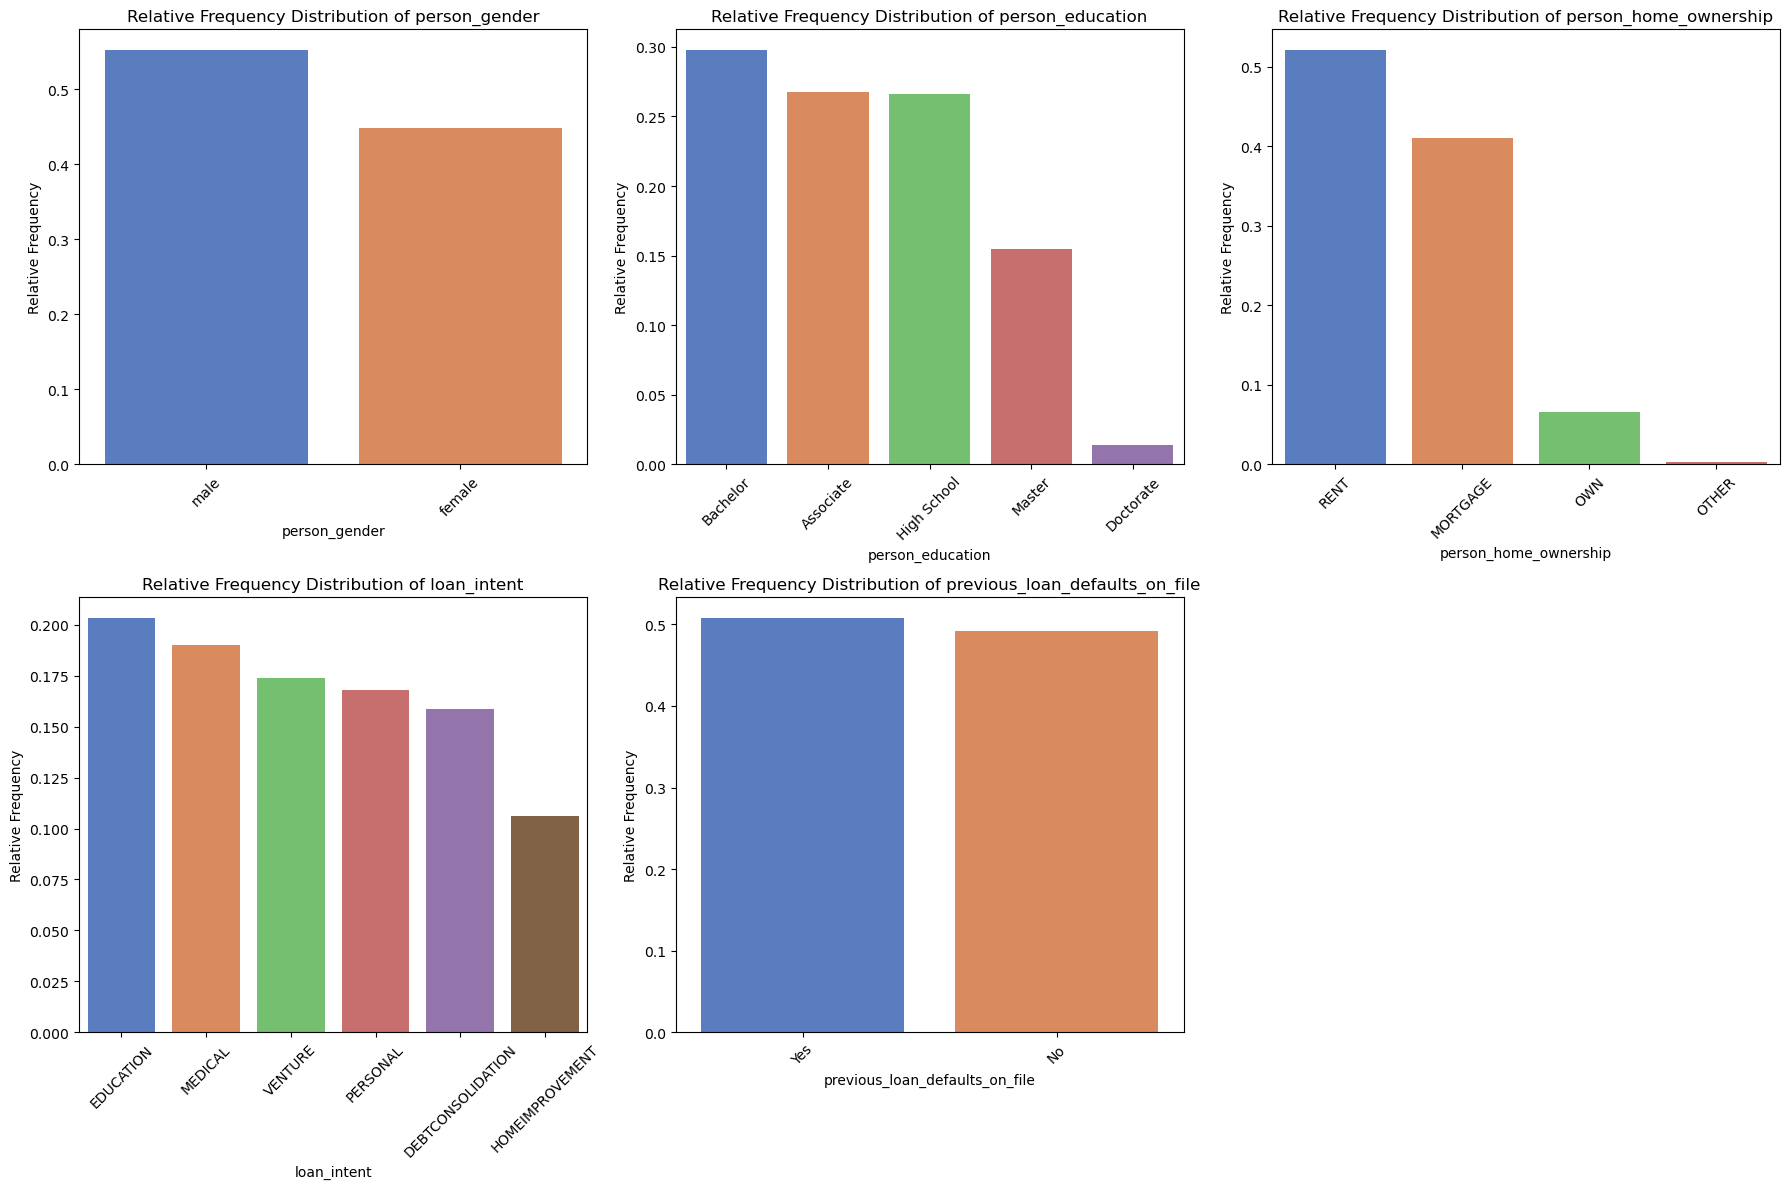

In [6]:
# Create a grid layout for bar plots
fig, axes = plt.subplots(2, (len(categorical_columns) + 1) // 2, figsize=(18, 12))
axes = axes.flatten()

# Generate bar plots for each categorical variable with relative frequencies
for idx, var in enumerate(categorical_columns):
    # Calculate the relative frequency (proportions)
    freq = data[var].value_counts(normalize=True)
    
    # Use sns.barplot to plot the relative frequency
    sns.barplot(x=freq.index, hue=freq.index, y=freq.values, ax=axes[idx], palette="muted")
    
    axes[idx].set_title(f"Relative Frequency Distribution of {var}")
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel("Relative Frequency")
    axes[idx].tick_params(axis='x', rotation=45)

# Remove unused subplots if any
for ax in axes[len(categorical_columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


**Person Education:**
The majority of applicants hold a Bachelor's degree (29.8%), followed by an Associate degree (26.7%), High School diploma (26.6%), Master's degree (15.5%), and Doctorate (1.4%). This indicates a higher prevalence of individuals with undergraduate qualifications.

**Person Gender:**
There are more male applicants (55.2%) than female applicants (44.8%), showing a slight gender imbalance in the dataset.

**Person Home Ownership:**
Most applicants are renters (52.1%), followed by mortgage holders (41.1%), with a much smaller proportion owning homes (6.6%) or reporting other ownership statuses (0.3%).

**Loan intention:**
The purpose of the loans varies across categories. "Education" (20.3%) accounts for the highest proportion of loan applicants, followed by "Medical" (19.0%), "Venture" (17.4%), "Personal" (16.8%), "Debt Consolidation" (15.9%), and "Home Improvement" (10.6%).

**Indicator of previous loan defaults:**
The dataset shows that the proportion of applicants with a history of previous loan defaults is nearly evenly split.

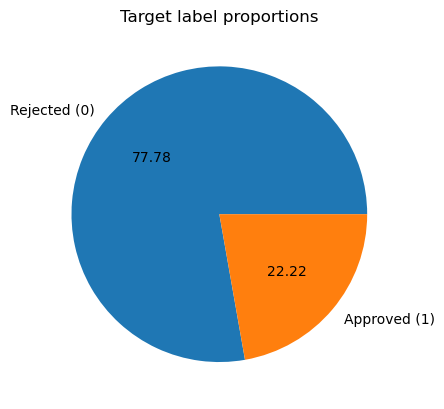

In [7]:
label_prop = data['loan_status'].value_counts()

plt.pie(label_prop.values, labels=['Rejected (0)', 'Approved (1)'], autopct='%.2f')
plt.title('Target label proportions')
plt.show()

Our dataset is imbalanced, which will be an important consideration when training models. To address this imbalance, techniques such as SMOTE may be applied to balance the dataset.

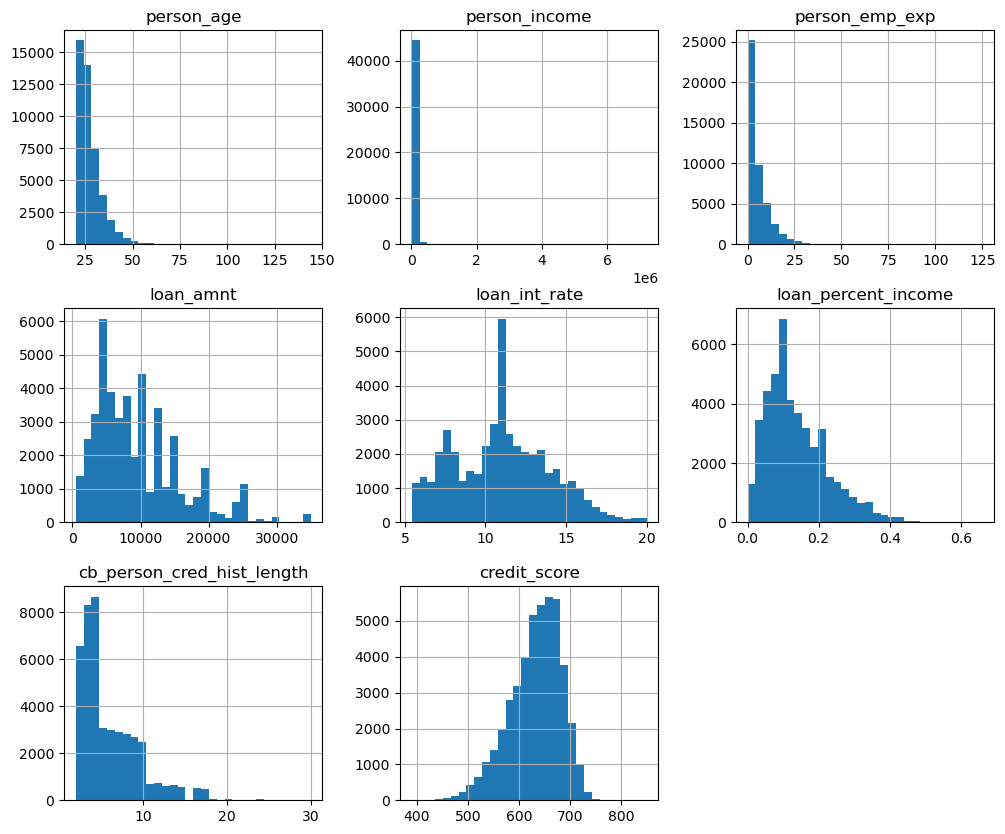

In [8]:
data[numerical_columns].hist(bins=30, figsize=(12,10))
plt.show()

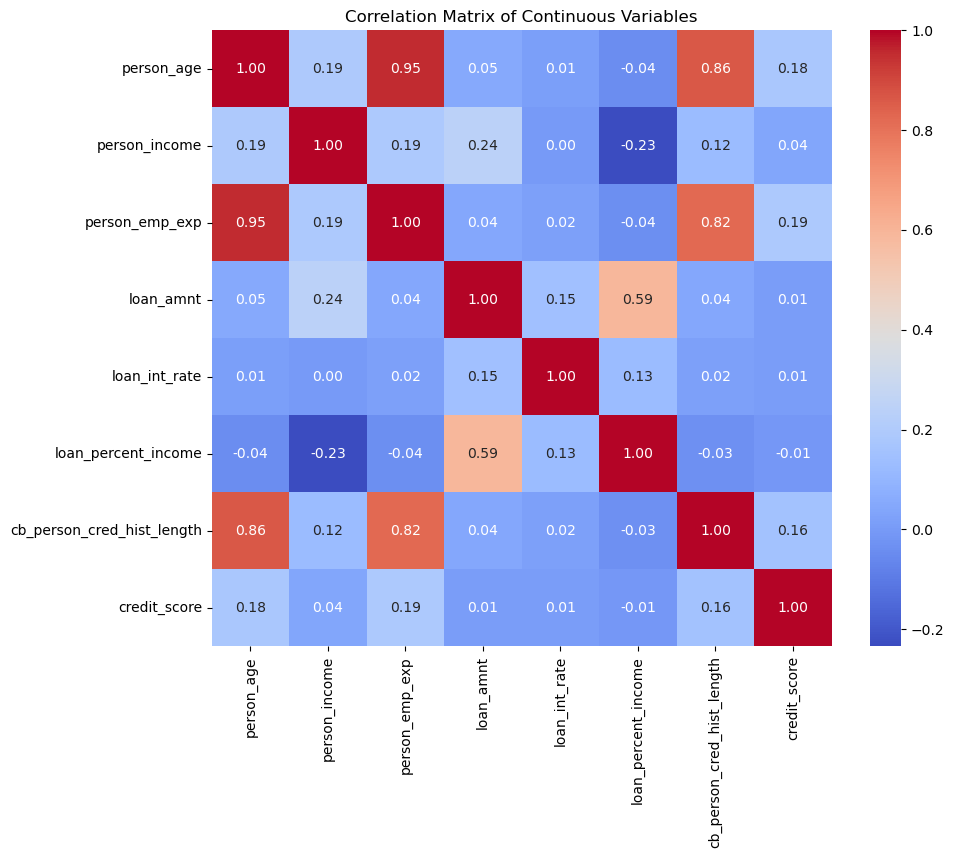

In [9]:
# Correlation heatmap
corr_matrix = data[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Continuous Variables")
plt.show()

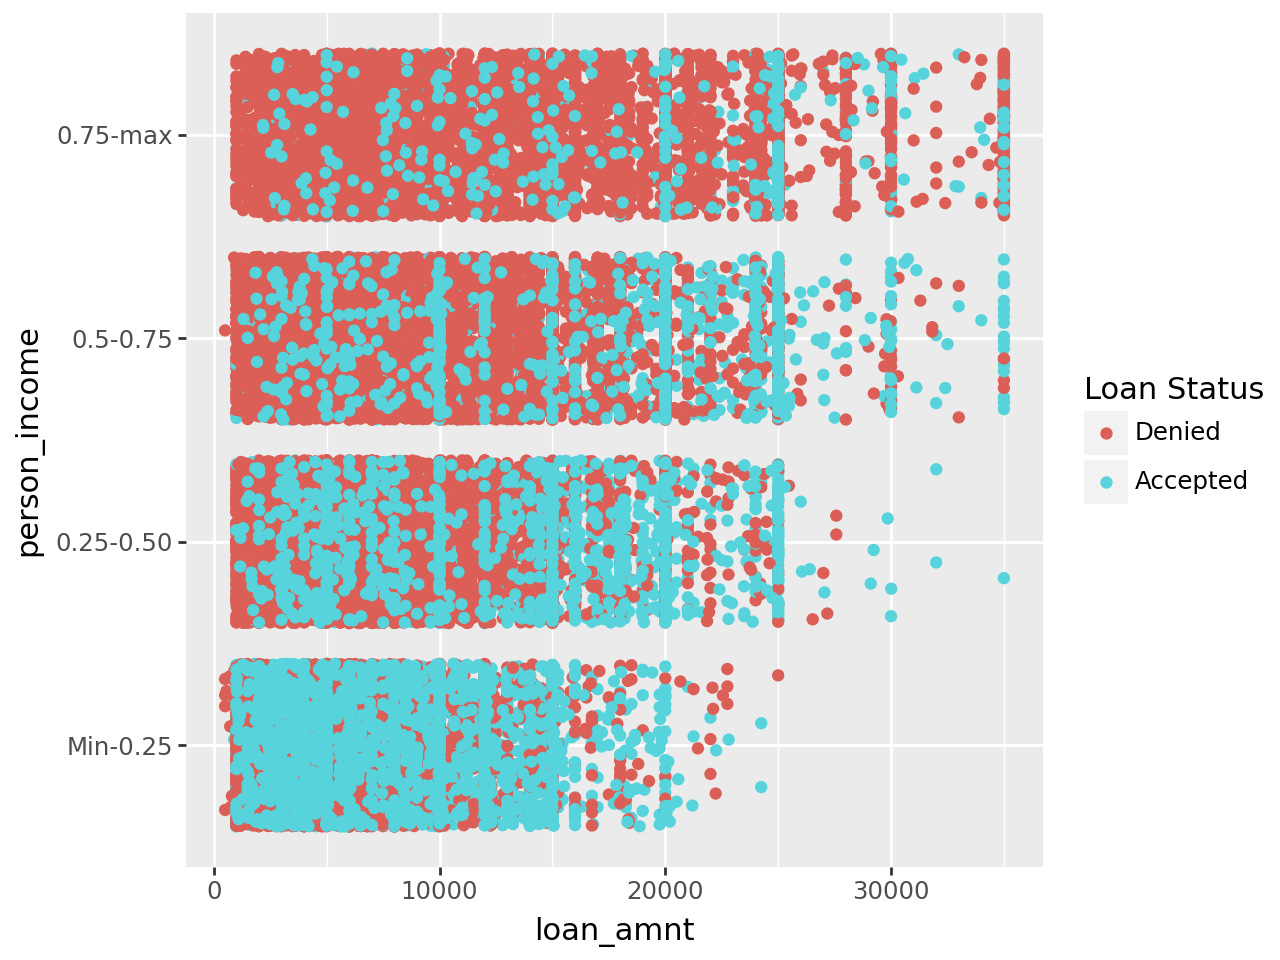

In [10]:
data1=data.copy()
Qtiles = data1.quantile([0.25, 0.50, 0.75], numeric_only=True)
data1["LS"] = pd.cut(data1.loan_status,bins = [-1,0,1], labels =["Denied", "Accepted"])
b = pd.qcut(data1.person_income,4,labels=["Min-0.25","0.25-0.50","0.5-0.75","0.75-max"])
b.value_counts().sort_index()
(p9.ggplot(
    data=data1,
    mapping = p9.aes(x="loan_amnt",y=b, color= "LS")
)
+
p9.geom_point(position = "jitter")
+
p9.scale_color_discrete(name = "Loan Status")
)
#Lower income = more likely to get a loan?

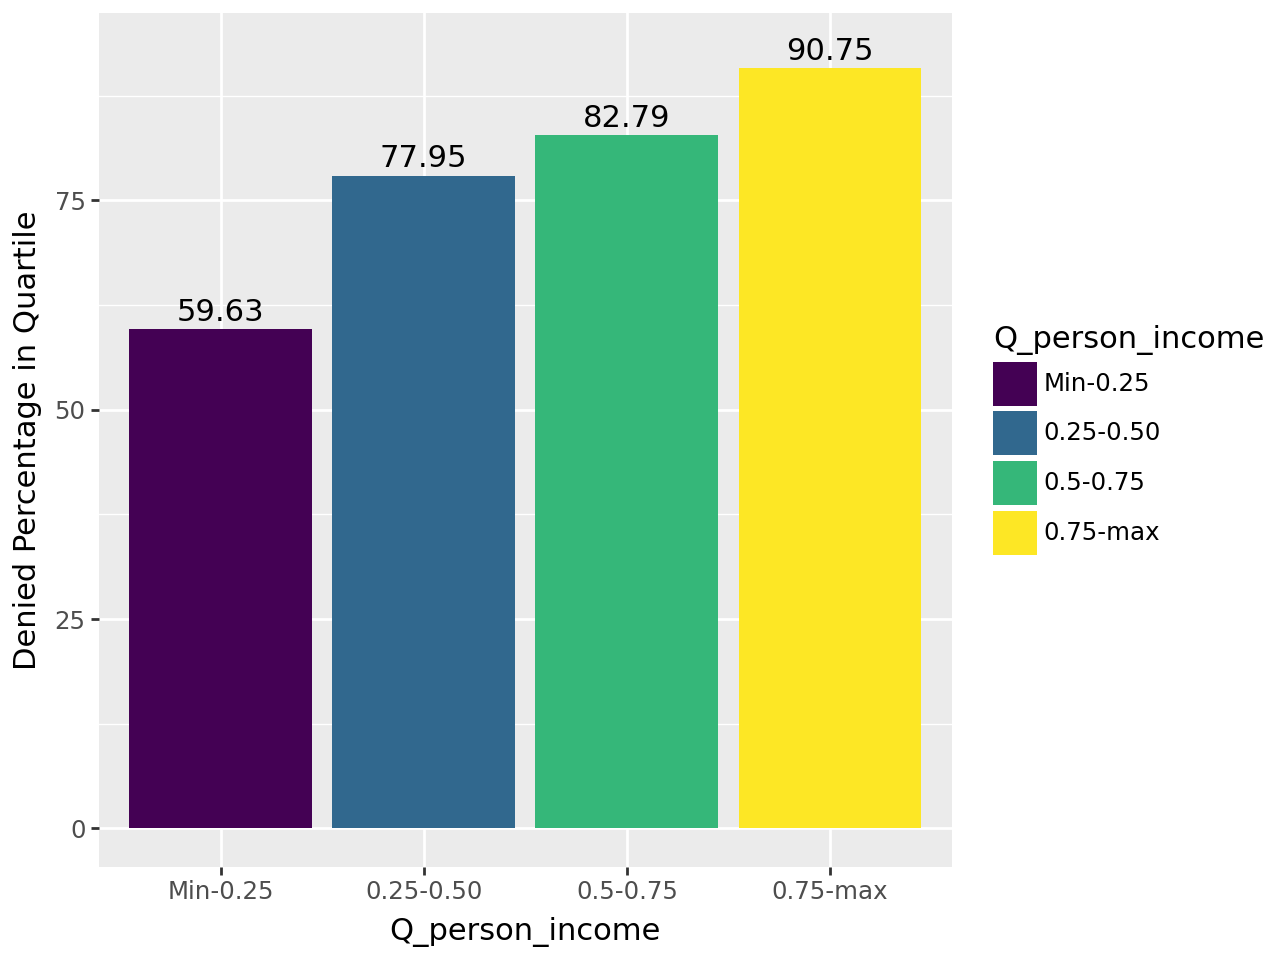

In [11]:
data1["Q_person_income"]=b
## Percentage in quartile
df_income = pd.DataFrame ({
    "Q_person_income": ["Min-0.25","0.25-0.50","0.5-0.75","0.75-max"] ,
    "Denied Percentage in Quartile": [
                    data1[(data1["Q_person_income"]=="Min-0.25")]["LS"].value_counts(normalize=True).mul(100)["Denied"],
                    data1[(data1["Q_person_income"]=="0.25-0.50")]["LS"].value_counts(normalize=True).mul(100)["Denied"],
                    data1[(data1["Q_person_income"]=="0.5-0.75")]["LS"].value_counts(normalize=True).mul(100)["Denied"],
                    data1[(data1["Q_person_income"]=="0.75-max")]["LS"].value_counts(normalize=True).mul(100)["Denied"]
                    ],
    "Accepted Percentage in Quartile": [
                    data1[(data1["Q_person_income"]=="Min-0.25")]["LS"].value_counts(normalize=True).mul(100)["Accepted"],
                    data1[(data1["Q_person_income"]=="0.25-0.50")]["LS"].value_counts(normalize=True).mul(100)["Accepted"],
                    data1[(data1["Q_person_income"]=="0.5-0.75")]["LS"].value_counts(normalize=True).mul(100)["Accepted"],
                    data1[(data1["Q_person_income"]=="0.75-max")]["LS"].value_counts(normalize=True).mul(100)["Accepted"]
                    ]
})

df_income["Q_person_income"] = pd.Categorical(df_income["Q_person_income"], categories=["Min-0.25","0.25-0.50","0.5-0.75","0.75-max"], ordered= True)
df_income
(p9.ggplot(
    data=df_income.round(2),
    mapping = p9.aes(x="Q_person_income",y="Denied Percentage in Quartile", fill="Q_person_income")
)
+
p9.geom_bar(stat="identity")
 +p9.geom_text(p9.aes(label = "Denied Percentage in Quartile"), nudge_y=2)
)

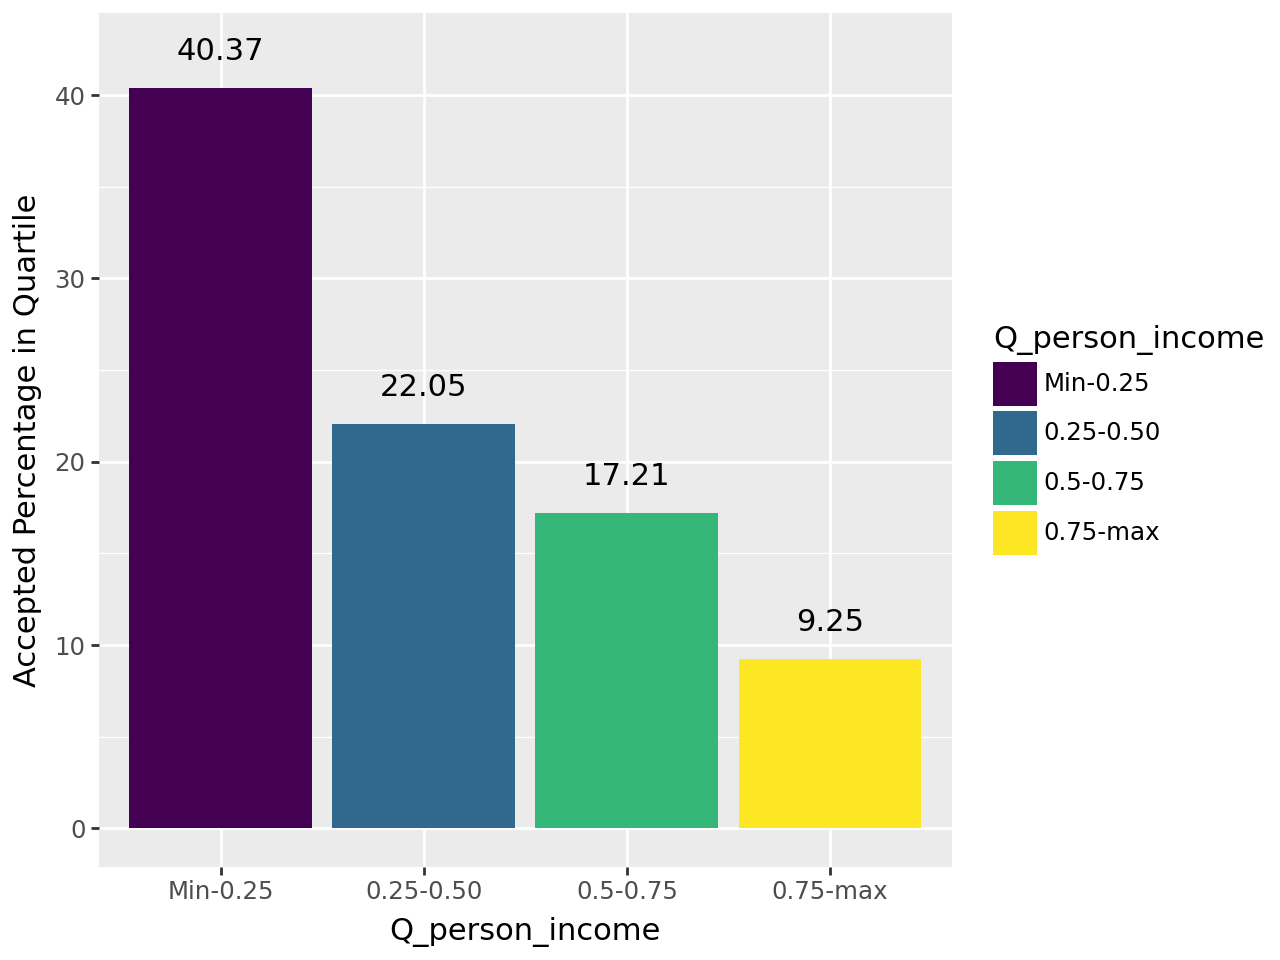

In [12]:
(p9.ggplot(
    data=df_income.round(2),
    mapping = p9.aes(x="Q_person_income",y="Accepted Percentage in Quartile", fill="Q_person_income")
)
+
p9.geom_bar(stat="identity")
 +p9.geom_text(p9.aes(label = "Accepted Percentage in Quartile"), nudge_y=2)
)

# 2. Data Cleaning

In [13]:
data_original = data.copy()

## Age
# Define a realistic maximum age
max_realistic_age = 100

# Drop rows where 'person_age' exceeds the maximum realistic age
data = data[data['person_age'] <= max_realistic_age]

# Check the result
data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,44993.000000,4.499300e+04,44993.000000,44993.000000,44993.000000,44993.000000,44993.000000,44993.000000,44993.000000
mean,27.748428,7.990845e+04,5.394528,9583.176761,11.006448,0.139736,5.866557,632.585713,0.222257
std,5.909737,6.332213e+04,5.927159,6314.802655,2.978985,0.087207,3.877167,50.402411,0.415767
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.719500e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704600e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.577800e+04,8.000000,12237.000000,12.990000,0.190000,8.000000,670.000000,0.000000
max,94.000000,2.448661e+06,76.000000,35000.000000,20.000000,0.660000,30.000000,784.000000,1.000000


In [14]:
## Experience

# Calculate mean and standard deviation
mean = data['person_emp_exp'].mean()
std_dev = data['person_emp_exp'].std()

# Define an upper bound (e.g., 5 standard deviations)
upper_threshold = mean + 5 * std_dev

# Drop outliers
data = data[data['person_emp_exp'] <= upper_threshold]

# Check the updated statistics
data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,44887.000000,4.488700e+04,44887.000000,44887.000000,44887.000000,44887.000000,44887.000000,44887.000000,44887.000000
mean,27.663644,7.974008e+04,5.307550,9580.879832,11.006204,0.139746,5.824537,632.445051,0.222202
std,5.645097,6.127817e+04,5.649416,6310.755217,2.978740,0.087183,3.780256,50.333079,0.415731
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.716450e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704400e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,639.000000,0.000000
75%,30.000000,9.573200e+04,8.000000,12235.000000,12.990000,0.190000,8.000000,669.000000,0.000000
max,61.000000,2.448661e+06,35.000000,35000.000000,20.000000,0.660000,30.000000,768.000000,1.000000


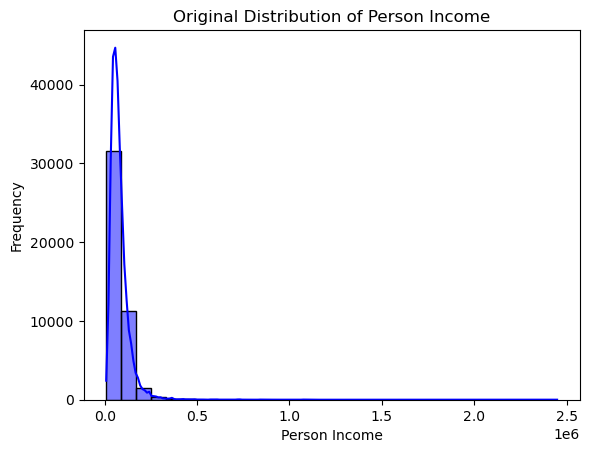

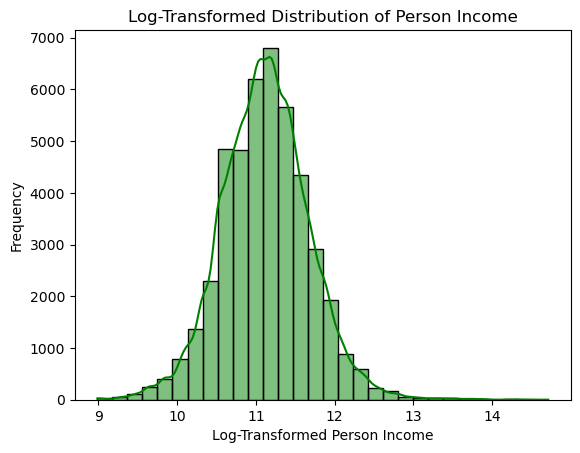

Number of outliers: 335
Original dataset size: 44887, Cleaned dataset size: 44552


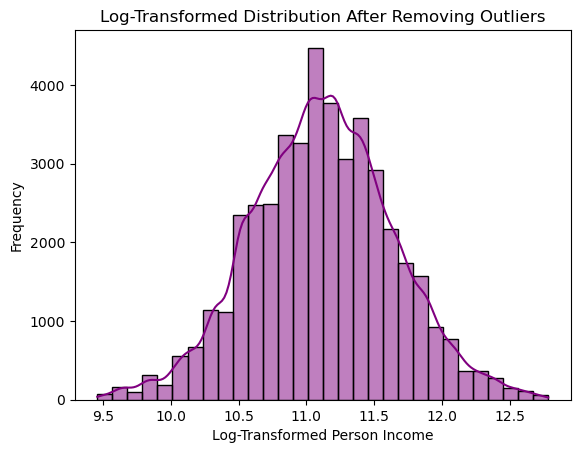

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,log_person_income
count,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000,44552.000000
mean,27.632923,77337.140645,5.277182,9563.223941,11.002163,0.140140,5.804139,632.417647,0.221292,11.115726
std,5.618403,44085.421882,5.622922,6267.010503,2.979124,0.087014,3.760581,50.314354,0.415121,0.528862
min,20.000000,12797.000000,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000,9.457044
25%,24.000000,47234.000000,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000,10.762890
50%,26.000000,67007.000000,4.000000,8000.000000,11.010000,0.120000,4.000000,639.000000,0.000000,11.112567
75%,30.000000,94844.000000,8.000000,12102.250000,12.990000,0.190000,8.000000,669.000000,0.000000,11.459999
max,61.000000,356880.000000,35.000000,35000.000000,20.000000,0.660000,30.000000,768.000000,1.000000,12.785158


In [15]:
## Personal Income

# Plot the original distribution
sns.histplot(data['person_income'], bins=30, kde=True, color='blue')
plt.title("Original Distribution of Person Income")
plt.xlabel("Person Income")
plt.ylabel("Frequency")
plt.show()

# Apply log transformation
data['log_person_income'] = np.log1p(data['person_income'])  # log1p handles log(0) gracefully

# Plot the transformed distribution
sns.histplot(data['log_person_income'], bins=30, kde=True, color='green')
plt.title("Log-Transformed Distribution of Person Income")
plt.xlabel("Log-Transformed Person Income")
plt.ylabel("Frequency")
plt.show()

# Calculate Z-scores and identify outliers
z_scores = zscore(data['log_person_income'])  # Compute Z-scores for the log-transformed variable
data['z_score_person_income'] = z_scores  # Optional: store Z-scores for review

# Define a threshold for Z-scores
threshold = 3  # Common threshold (3 standard deviations from the mean)

# Identify outliers
outliers = data[np.abs(z_scores) > threshold]
print(f"\033[1mNumber of outliers:\033[0m {len(outliers)}")

# Drop outliers
data_cleaned = data[np.abs(z_scores) <= threshold]

# Check the shape after cleaning
print(f"\033[1mOriginal dataset size:\033[0m {len(data)}, \033[1mCleaned dataset size:\033[0m {len(data_cleaned)}")

# Plot the cleaned log-transformed distribution
sns.histplot(data_cleaned['log_person_income'], bins=30, kde=True, color='purple')
plt.title("Log-Transformed Distribution After Removing Outliers")
plt.xlabel("Log-Transformed Person Income")
plt.ylabel("Frequency")
plt.show()

with warnings.catch_warnings(action="ignore"): #SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame
    data_cleaned.drop('z_score_person_income', axis=1, inplace=True)

data_cleaned.describe()

# 3. Feature Engineering

In [16]:
# One-Hot Encoding for nominal variables
# We apply one-hot encoding for nominal variables using pd.get_dummies
data_cleaned = pd.get_dummies(data_cleaned, columns=['person_gender', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file'], drop_first=True)

# Label Encoding for ordinal variables
# Assuming person_education is an ordinal variable with a natural order

columns_to_encode = ['person_education']
label_encoder = LabelEncoder()

# Apply Label Encoding to each column in the list
data_cleaned[columns_to_encode] = data_cleaned[columns_to_encode].apply(label_encoder.fit_transform)
data_cleaned1 = data_cleaned.copy(deep=True)
data_cleaned2 = data_cleaned.copy(deep=True)
data_cleaned3 = data_cleaned.copy(deep=True)

# 4. Training Models

## 4.1 SVM

In [17]:
# Split the data into features (X) and target (y)
X = data_cleaned1.drop('loan_status', axis=1)  # Drop 'loan_status' as it's the target
y = data_cleaned1['loan_status']  # 'loan_status' is the target column

# Split into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training data into training (70%) and validation (30%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print(f"Original training set shape: {y_train.value_counts()}")
print(f"Resampled training set shape: {y_train_res.value_counts()}")

Original training set shape: loan_status
0    19427
1     5521
Name: count, dtype: int64
Resampled training set shape: loan_status
1    19427
0    19427
Name: count, dtype: int64


In [18]:
def evaluate_kernel(X_train, y_train, param_dist):
    """Performs GridSearchCV for a given kernel and returns the best estimator and parameters."""
    # Define the pipeline with scaling and SVM
    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('svm', SVC(probability=True)) 
    ])
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=svm_pipeline,
        param_grid=param_dist,  # Use dynamically passed parameter grid
        cv=StratifiedKFold(n_splits=5),
        scoring='roc_auc',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train_res, y_train_res)
    
    return grid_search.best_estimator_, grid_search.best_params_


In [19]:

param_dist_linear = {
    'svm__C': [0.1, 1],
    'svm__kernel': ['linear']
}

param_dist_rbf = {
    'svm__C': [0.1, 1],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf']
}

param_dist_poly = {
    'svm__C': [0.1, 1],
    'svm__degree': [2, 3],
    'svm__kernel': ['poly']
}


### Rerun

In [ ]:
# Evaluate linear kernel
print("Evaluating Linear Kernel")
best_model_linear, best_params_linear = evaluate_kernel(X_train_res, y_train_res, param_dist_linear)

# Evaluate rbf kernel
print("Evaluating RBF Kernel")
best_model_rbf, best_params_rbf = evaluate_kernel(X_train_res, y_train_res, param_dist_rbf)

# Evaluate poly kernel
print("Evaluating Polynomial Kernel")
best_model_poly, best_params_poly = evaluate_kernel(X_train_res, y_train_res, param_dist_poly)


### Import

In [20]:
# Linear kernel import
best_model_linear = pickle.load(open("models/svm_model_linear.pkl",'rb'))
best_params_linear = best_model_linear.get_params()
# Evaluate rbf kernel
best_model_rbf = pickle.load(open('models/svm_model_rbf.pkl','rb'))
best_params_rbf = best_model_rbf.get_params()
# Evaluate poly kernel
best_model_poly = pickle.load(open('models/svm_model_poly.pkl','rb'))
best_params_poly = best_model_linear.get_params()

### Evaluate

In [21]:
# Evaluate ROC AUC on the validation set for each model
best_models = {
    'linear': (best_model_linear, best_params_linear),
    'rbf': (best_model_rbf, best_params_rbf),
    'poly': (best_model_poly, best_params_poly)
}

print("\nComparing Models Across Kernels...\n")
with warnings.catch_warnings(action="ignore"): # UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
    roc_auc_scores = {}
    for kernel, (model, params) in best_models.items():
        # Scale validation data using the scaler from the pipeline
        X_val_scaled = model.named_steps['scaler'].transform(X_val)
        
        # Predict probabilities
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        
        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        roc_auc_scores[kernel] = roc_auc

        print(f"\033[1mKernel:\033[0m {kernel},\n\033[1mROC AUC:\033[0m {roc_auc:.4f}, \n\033[1mBest Params:\033[0m")
        for key, value in params.items():
            print ("\t" + str(key)+ ": "+ str(value))
        print("\n")  
    
    # Determine the best-performing kernel
    best_kernel = max(roc_auc_scores, key=roc_auc_scores.get)
    print(f"\033[1m\nBest Kernel:\033[0m {best_kernel} \n\033[1mROC AUC:\033[0m {roc_auc_scores[best_kernel]:.4f}")



Comparing Models Across Kernels...

Kernel: linear,
ROC AUC: 0.8440, 
Best Params:
	memory: None
	steps: [('scaler', StandardScaler()), ('svm', SVC(C=1, kernel='linear', probability=True))]
	verbose: False
	scaler: StandardScaler()
	svm: SVC(C=1, kernel='linear', probability=True)
	scaler__copy: True
	scaler__with_mean: True
	scaler__with_std: True
	svm__C: 1
	svm__break_ties: False
	svm__cache_size: 200
	svm__class_weight: None
	svm__coef0: 0.0
	svm__decision_function_shape: ovr
	svm__degree: 3
	svm__gamma: scale
	svm__kernel: linear
	svm__max_iter: -1
	svm__probability: True
	svm__random_state: None
	svm__shrinking: True
	svm__tol: 0.001
	svm__verbose: False


Kernel: rbf,
ROC AUC: 0.7825, 
Best Params:
	memory: None
	steps: [('scaler', StandardScaler()), ('svm', SVC(C=1, probability=True))]
	verbose: False
	scaler: StandardScaler()
	svm: SVC(C=1, probability=True)
	scaler__copy: True
	scaler__with_mean: True
	scaler__with_std: True
	svm__C: 1
	svm__break_ties: False
	svm__cache_siz

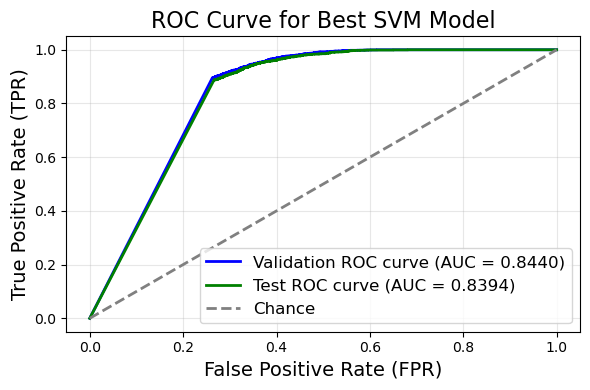

Best Kernel: linear
Validation ROC AUC: 0.8440
Test ROC AUC: 0.8394


In [22]:
# Select the best model based on `best_kernel`
best_model = best_models[best_kernel][0]  # Retrieve the best model pipeline
best_params = best_models[best_kernel][1]  # Retrieve the best parameters

# Scale validation and test data using the scaler from the best pipeline
X_val_scaled = best_model.named_steps['scaler'].transform(X_val)
X_test_scaled = best_model.named_steps['scaler'].transform(X_test)

# Predict probabilities for validation and test sets
with warnings.catch_warnings(action="ignore"): # UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
    y_val_prob = best_model.predict_proba(X_val_scaled)[:, 1]
    y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curves
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

# Compute AUC scores
roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(6, 4))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Validation ROC curve (AUC = {roc_auc_val:.4f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.4f})')

# Add diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Chance')

# Customize the plot
plt.title('ROC Curve for Best SVM Model', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
# Bold text with "\033[1mTEXT\033[0m
# Print AUC scores
print(f"\033[1mBest Kernel:\033[0m {best_kernel}")
print(f"\033[1mValidation ROC AUC:\033[0m {roc_auc_val:.4f}")
print(f"\033[1mTest ROC AUC:\033[0m {roc_auc_test:.4f}")

## 4.2 Logistic

### Rerun 

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Set up the parameter grid for Logistic Regression
log_param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [300, 500, 1000],  # Increased iterations
    'solver': ['lbfgs', 'liblinear']
}

# Initialize Logistic Regression model
log_model = LogisticRegression()

# Perform grid search with 10-fold cross-validation
log_grid_search = GridSearchCV(
    estimator=log_model,
    param_grid=log_param_grid,
    cv=StratifiedKFold(n_splits=10),
    scoring='roc_auc',
    verbose=1  # To track progress
)

# Fit the grid search to the scaled training data
log_grid_search.fit(X_train_res_scaled, y_train_res)

# Fit the best model from GridSearchCV on the scaled training data
best_log_model = log_grid_search.best_estimator_

### Import 

In [24]:
# Fit the best model from GridSearchCV on the scaled training data
best_log_model = pickle.load(open('models/best_logistic_model.pkl','rb'))

### Evaluation

In [25]:
# Best hyperparameters
print("\033[1mBest Logistic Regression Hyperparameters:\033[0m")

for key, value in best_log_model.get_params().items():
    print ("\t" + str(key)+ ": "+ str(value))



Best Logistic Regression Hyperparameters:
	C: 10
	class_weight: None
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 300
	multi_class: deprecated
	n_jobs: None
	penalty: l2
	random_state: None
	solver: lbfgs
	tol: 0.0001
	verbose: 0
	warm_start: False


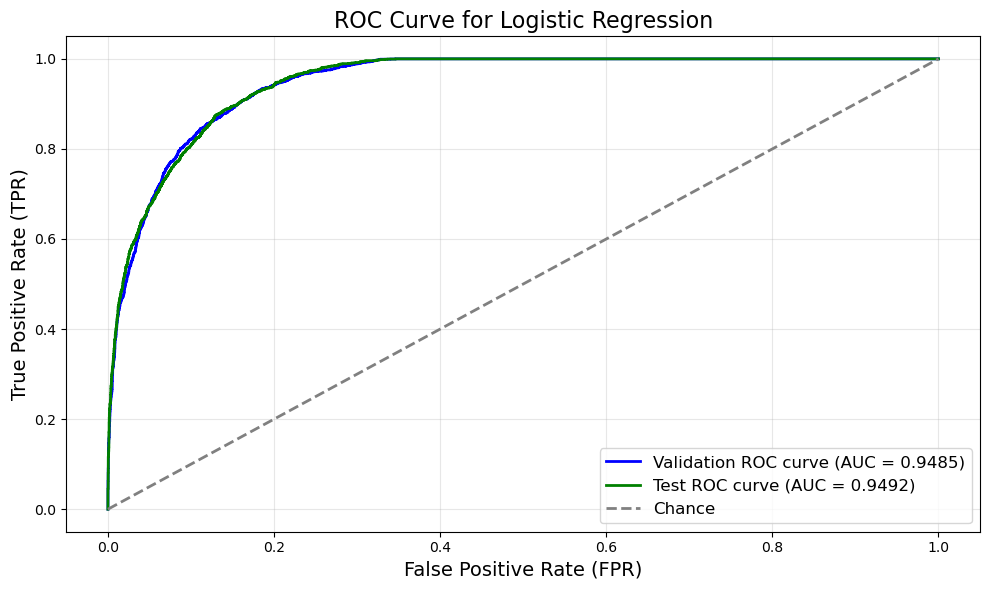

In [26]:
# Predict probabilities for the validation and test sets
y_val_prob = best_log_model.predict_proba(X_val_scaled)[:, 1]
y_test_prob = best_log_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve for validation and test sets
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

# Compute AUC scores for validation and test sets
roc_auc_val = auc(fpr_val, tpr_val)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Validation ROC curve (AUC = {roc_auc_val:.4f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.4f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Chance')

# Customize the plot
plt.title('ROC Curve for Logistic Regression', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [27]:
def calculate_metrics(model, X_test, y_test):
    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return precision, recall, f1, accuracy, roc_auc

# Create a dictionary to store the metrics
metrics_data = {}

# Calculate metrics for Linear SVM
linear_metrics = calculate_metrics(best_model_linear, X_test, y_test)
metrics_data['Linear SVM'] = linear_metrics

# Calculate metrics for Poly SVM
poly_metrics = calculate_metrics(best_model_poly, X_test, y_test)
metrics_data['Poly SVM'] = poly_metrics

# Calculate metrics for RBF SVM
rbf_metrics = calculate_metrics(best_model_rbf, X_test, y_test)
metrics_data['RBF SVM'] = rbf_metrics

# Calculate metrics for Logistic Regression
log_metrics = calculate_metrics(best_log_model, X_test_scaled, y_test)
metrics_data['Logistic Regression'] = log_metrics

# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data, index=['Precision', 'Recall', 'F1-Score', 'Accuracy', 'ROC AUC'])

# Display the DataFrame
print(metrics_df)


           Linear SVM  Poly SVM   RBF SVM  Logistic Regression
Precision    0.662510  0.716981  0.723701             0.663915
Recall       0.862069  0.867140  0.868661             0.856491
F1-Score     0.749229  0.784944  0.789583             0.748007
Accuracy     0.872293  0.894849  0.897542             0.872293
ROC AUC      0.949662  0.959475  0.959713             0.949180


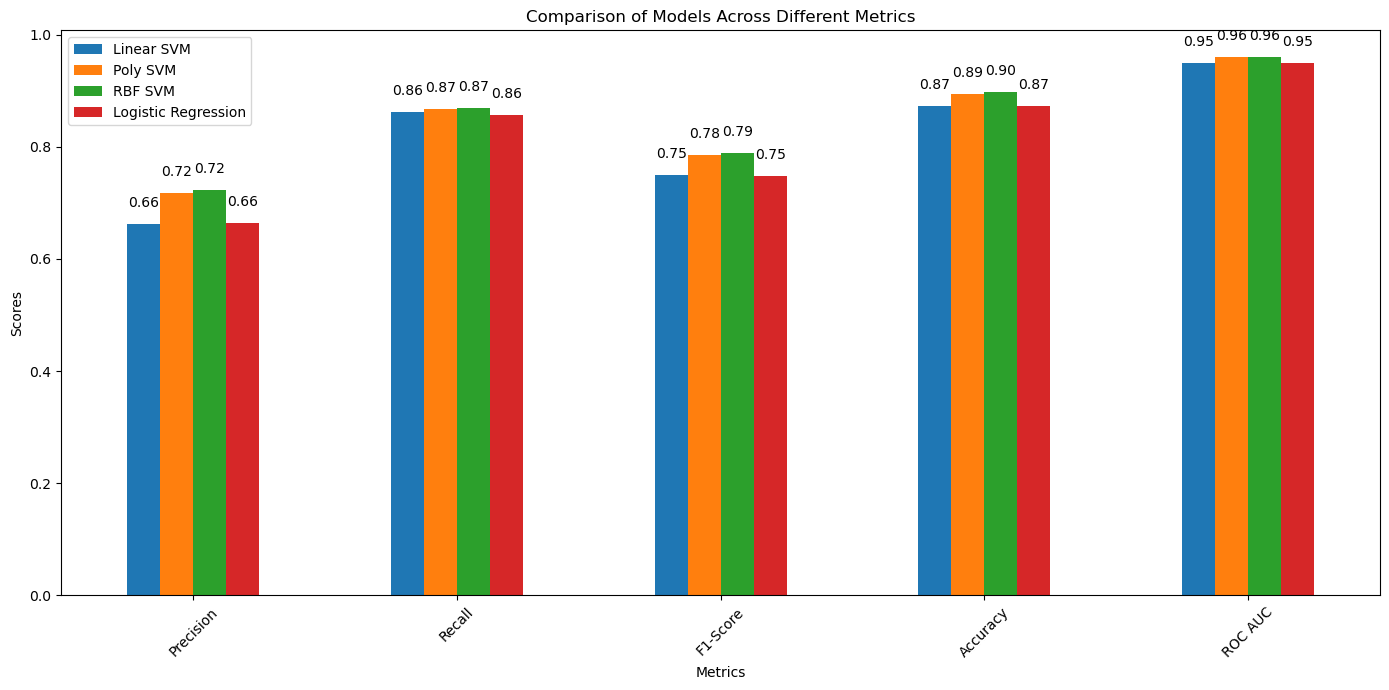

In [29]:
# Create a DataFrame from the metrics_data
metrics_df = pd.DataFrame(metrics_data, index=['Precision', 'Recall', 'F1-Score', 'Accuracy', 'ROC AUC'])

# Plotting the metrics for comparison
fig, ax = plt.subplots(figsize=(14, 7))

# Plotting the bar plot
metrics_df.plot(kind='bar', ax=ax)

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Models Across Different Metrics')

# Adding percentage on top of each bar with adjusted spacing
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom',  # Positioning below the label
                fontsize=10, color='black', 
                xytext=(0, 10), textcoords='offset points')  # Adjusted the spacing to 5

# Displaying the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4.3 Neural Networks

In [30]:
data_cleaned2['log_loan_amnt'] = np.log1p(data_cleaned2['loan_amnt'])
data_cleaned2 = data_cleaned2.drop(columns=['person_income', 'loan_amnt'])

# Set the random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Set seed for random processes in other libraries 
random.seed(seed_value)

In [31]:
# Prepare the data for training
X = data_cleaned2.drop(columns=['loan_status'])  # Features
y = data_cleaned2['loan_status']  # Target variable

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed_value)

### Neural Network with hyperparameter tuning

In [32]:
# Define the function to build the model
def build_model(hp):
    model = Sequential()
    
    # Choose activation function for the input layer
    activation_input = hp.Choice('activation_input', ['relu', 'tanh', 'sigmoid', 'elu', 'swish', 'selu'])
    model.add(
        Dense(
            units=hp.Int("units_input", min_value=32, max_value=512, step=32),
            activation=activation_input,  # Use dynamic activation function for the input layer
            input_dim=X_train.shape[1],
        )
    )
    
    # Hidden layers with hyperparameters for units, activation, and dropout
    for i in range(hp.Int("num_hidden_layers", 1, 5)):  # Up to 5 hidden layers
        activation_hidden = hp.Choice(f'activation_hidden_{i}', ['relu', 'tanh', 'sigmoid', 'elu', 'swish', 'selu'])
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=activation_hidden,  # Dynamic activation function for each hidden layer
            )
        )
        model.add(Dropout(rate=hp.Float(f"dropout_{i}", 0.0, 0.6, step=0.05)))  # Dropout rates
    
    # Output layer (binary classification so sigmoid is generally used)
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model with learning rate as a hyperparameter
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-1, 1e-2, 1e-3, 1e-4])
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss (you can also use 'val_accuracy')
    patience=5,  # Stop after 5 epochs without improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1  # To see the status of early stopping
)

# Initialize KerasTuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",  # You can change this to 'val_loss' if you prefer
    max_epochs=20,  # Allow for longer training
    factor=3,
    directory="models/kt_tuner_wide",
    project_name="lc_wide",
)

# Search for the best hyperparameters
tuner.search(
    X_train, 
    y_train, 
    validation_split=0.2, 
    epochs=20, 
    verbose=1, 
    callbacks=[early_stopping]  # Include early stopping in the training process
)

# Get the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("The optimal hyperparameters are:")
print(f" - Input layer units: {best_hps.get('units_input')}")
for i in range(best_hps.get("num_hidden_layers")):
    print(
        f" - Hidden layer {i + 1} units: {best_hps.get(f'units_{i}')}, "
        f"dropout: {best_hps.get(f'dropout_{i}')}, "
        f"activation: {best_hps.get(f'activation_hidden_{i}')}"
    )
print(f" - Learning rate: {best_hps.get('learning_rate')}")

# Train the model with the best hyperparameters
with warnings.catch_warnings(action="ignore"):#UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
    best_model = tuner.hypermodel.build(best_hps)
best_model.fit(
    X_train, 
    y_train, 
    validation_split=0.2, 
    epochs=30,  # You can keep this higher to ensure you have enough time to catch early stopping
    verbose=1, 
    callbacks=[early_stopping]  # Add early stopping here as well
)

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\033[1mTest Accuracy:\033[0m {accuracy:.2f}")

Reloading Tuner from models/kt_tuner_wide\lc_wide\tuner0.json
The optimal hyperparameters are:
 - Input layer units: 224
 - Hidden layer 1 units: 416, dropout: 0.0, activation: relu
 - Hidden layer 2 units: 384, dropout: 0.2, activation: tanh
 - Hidden layer 3 units: 32, dropout: 0.0, activation: relu
 - Learning rate: 0.0001
Epoch 1/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8756 - loss: 0.2861 - val_accuracy: 0.9045 - val_loss: 0.2068
Epoch 2/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9101 - loss: 0.1976 - val_accuracy: 0.9081 - val_loss: 0.1977
Epoch 3/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9155 - loss: 0.1891 - val_accuracy: 0.9137 - val_loss: 0.1914
Epoch 4/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9175 - loss: 0.1834 - val_accuracy: 0.9144 - val_loss: 0.1882
Epoch 5/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9187 - loss: 0.1799 - val_accuracy: 0.9158 - val_loss: 0.1861
Epoch 6/30
891/891 ━━━━━━━━━━━━━

#### Visualization

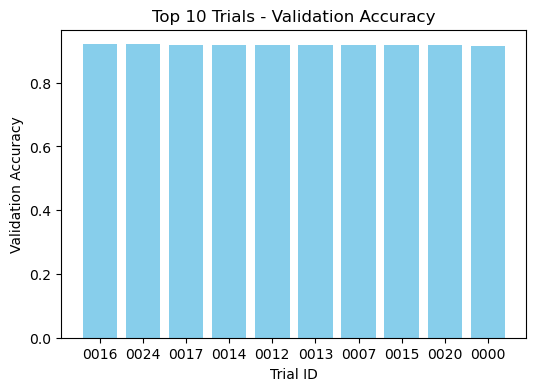

Epoch 1/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8703 - loss: 0.2820 - val_accuracy: 0.9074 - val_loss: 0.2052
Epoch 2/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9100 - loss: 0.1955 - val_accuracy: 0.9116 - val_loss: 0.1940
Epoch 3/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9154 - loss: 0.1870 - val_accuracy: 0.9140 - val_loss: 0.1893
Epoch 4/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9156 - loss: 0.1812 - val_accuracy: 0.9150 - val_loss: 0.1858
Epoch 5/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9192 - loss: 0.1775 - val_accuracy: 0.9185 - val_loss: 0.1832
Epoch 6/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9214 - loss: 0.1740 - val_accuracy: 0.9184 - val_loss: 0.1822
Epoch 7/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9209 - loss: 0.1719 - val_accuracy: 0.9195 - val_loss: 0.1815
Epoch 8/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9223 - loss: 0.1699 - val_accuracy: 0.

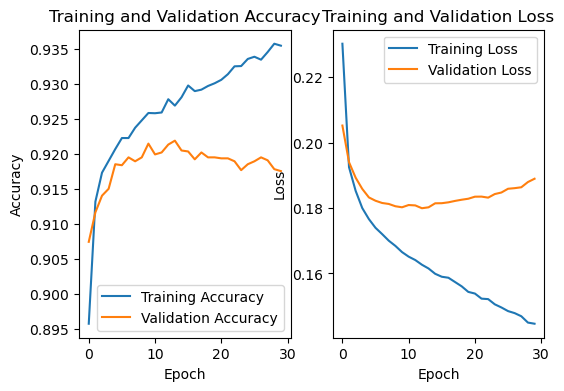

In [33]:
# Visualize the tuning results
def plot_tuning_results(tuner):
    trials = tuner.oracle.get_best_trials(num_trials=10)  # Get top 10 trials
    val_accuracies = [trial.metrics.get_best_value("val_accuracy") for trial in trials]
    trial_ids = [trial.trial_id for trial in trials]
    
    plt.figure(figsize=(6, 4))
    plt.bar(trial_ids, val_accuracies, color='skyblue')
    plt.xlabel('Trial ID')
    plt.ylabel('Validation Accuracy')
    plt.title('Top 10 Trials - Validation Accuracy')
    plt.show()

# Visualize training and validation curves
def plot_training_history(history):
    plt.figure(figsize=(6, 4))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Call the visualization functions after tuning and training
plot_tuning_results(tuner)
# Train the best model and plot its performance
with warnings.catch_warnings(action="ignore"): #UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
    best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=30, verbose=1)

plot_training_history(history)


279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step


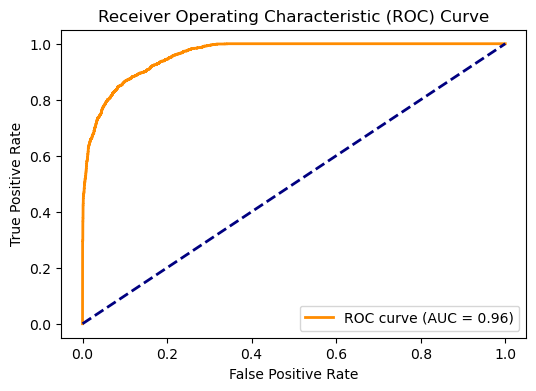

In [34]:
# Function to plot the ROC curve
def plot_roc_curve(model, X_test, y_test):
    # Predict probabilities
    y_prob = model.predict(X_test).ravel()
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = sklearn_auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

# Evaluate the ROC curve for the best model
NN_roc_auc= plot_roc_curve(best_model, X_test, y_test)

In [35]:
# Predict probabilities and class labels for the test set
y_pred_probs = best_model.predict(X_test).ravel()  # Predict probabilities
y_pred_classes = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary class predictions

# Generate classification report
report_NN = classification_report(y_test, y_pred_classes, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))


279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      6958
           1       0.83      0.76      0.79      1953

    accuracy                           0.91      8911
   macro avg       0.88      0.86      0.87      8911
weighted avg       0.91      0.91      0.91      8911



### Handling imbalanced data: Neural Network with class weights

In [36]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=seed_value)

y_train = np.array(y_train)
y_test = np.array(y_test)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define the function to build the model
def build_model(hp):
    model = Sequential()
    
    # Choose activation function for the input layer
    activation_input = hp.Choice('activation_input', ['relu', 'tanh', 'sigmoid', 'elu', 'swish', 'selu'])
    model.add(
        Dense(
            units=hp.Int("units_input", min_value=32, max_value=512, step=32),
            activation=activation_input,  # Use dynamic activation function for the input layer
            input_dim=X_train.shape[1],
        )
    )
    
    # Hidden layers with hyperparameters for units, activation, and dropout
    for i in range(hp.Int("num_hidden_layers", 1, 5)):  # Up to 5 hidden layers
        activation_hidden = hp.Choice(f'activation_hidden_{i}', ['relu', 'tanh', 'sigmoid', 'elu', 'swish', 'selu'])
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=activation_hidden,  # Dynamic activation function for each hidden layer
            )
        )
        model.add(Dropout(rate=hp.Float(f"dropout_{i}", 0.0, 0.6, step=0.05)))  # Dropout rates
    
    # Output layer (binary classification so sigmoid is generally used)
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model with learning rate as a hyperparameter
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", [1e-1, 1e-2, 1e-3, 1e-4])
        ),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),  # Monitor precision
            tf.keras.metrics.Recall(name='recall'),        # Monitor recall
            tf.keras.metrics.AUC(name='auc')              # Monitor AUC
        ],
    )
    
    return model

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop after 5 epochs without improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1  # To see the status of early stopping
)

# Initialize KerasTuner
tuner = kt.Hyperband(
    build_model,
    objective="val_auc",  # Use AUC to handle imbalanced data
    max_epochs=20,  # Allow for longer training
    factor=3,
    directory="models/kt_tuner_imbalanced",
    project_name="imbalanced_data_1",
)

# Search for the best hyperparameters
tuner.search(
    X_train, 
    y_train, 
    validation_split=0.2, 
    epochs=20, 
    verbose=1, 
    class_weight=class_weight_dict, 
    callbacks=[early_stopping]
)

# Get the best hyperparameters and print them
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("The optimal hyperparameters are:")
print(f" - Input layer units: {best_hps.get('units_input')}")
for i in range(best_hps.get("num_hidden_layers")):
    print(
        f" - Hidden layer {i + 1} units: {best_hps.get(f'units_{i}')}, "
        f"dropout: {best_hps.get(f'dropout_{i}')}, "
        f"activation: {best_hps.get(f'activation_hidden_{i}')}"
    )
print(f" - Learning rate: {best_hps.get('learning_rate')}")


# Train the model with the best hyperparameters
with warnings.catch_warnings(action="ignore"):#UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
    best_model = tuner.hypermodel.build(best_hps)
    best_model.fit(
        X_train, 
        y_train, 
        validation_split=0.2, 
        epochs=30,  # You can keep this higher to ensure you have enough time to catch early stopping
        verbose=1, 
        callbacks=[early_stopping],  # Add early stopping here as well
        class_weight=class_weight_dict # Pass class weights for final training
    )

# Evaluate the model
loss, accuracy, precision, recall, auc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\033[1mTest Accuracy:\033[0m {accuracy:.2f}")
print(f"\033[1mTest Precision:\033[0m {precision:.2f}")
print(f"\033[1mTest Recall:\033[0m {recall:.2f}")
print(f"\033[1mTest AUC:\033[0m {auc:.2f}")


Reloading Tuner from models/kt_tuner_imbalanced\imbalanced_data_1\tuner0.json
The optimal hyperparameters are:
 - Input layer units: 416
 - Hidden layer 1 units: 352, dropout: 0.35000000000000003, activation: tanh
 - Hidden layer 2 units: 128, dropout: 0.1, activation: selu
 - Hidden layer 3 units: 480, dropout: 0.25, activation: swish
 - Hidden layer 4 units: 256, dropout: 0.35000000000000003, activation: selu
 - Hidden layer 5 units: 480, dropout: 0.35000000000000003, activation: swish
 - Learning rate: 0.0001
Epoch 1/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8213 - auc: 0.9272 - loss: 0.3373 - precision: 0.5651 - recall: 0.9085 - val_accuracy: 0.8422 - val_auc: 0.9556 - val_loss: 0.3131 - val_precision: 0.5898 - val_recall: 0.9546
Epoch 2/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8589 - auc: 0.9562 - loss: 0.2557 - precision: 0.6237 - recall: 0.9262 - val_accuracy: 0.8485 - val_auc: 0.9580 - val_loss: 0.2997 - val_precision: 0.6004 - val_recall: 0.954

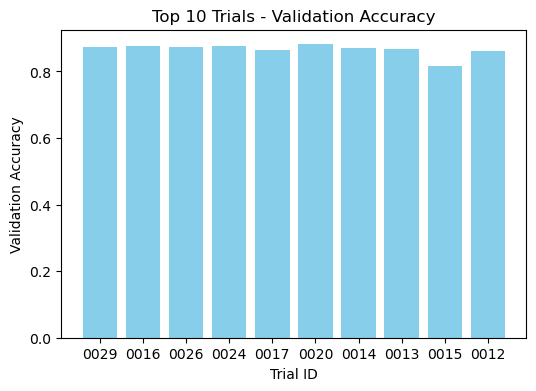

Epoch 1/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8592 - auc: 0.9152 - loss: 0.3092 - precision: 0.6781 - recall: 0.7337 - val_accuracy: 0.8949 - val_auc: 0.9551 - val_loss: 0.2240 - val_precision: 0.7398 - val_recall: 0.8140
Epoch 2/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8986 - auc: 0.9550 - loss: 0.2215 - precision: 0.7747 - recall: 0.7690 - val_accuracy: 0.9004 - val_auc: 0.9586 - val_loss: 0.2133 - val_precision: 0.7613 - val_recall: 0.8045
Epoch 3/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - auc: 0.9587 - loss: 0.2110 - precision: 0.7907 - recall: 0.7612 - val_accuracy: 0.9029 - val_auc: 0.9605 - val_loss: 0.2079 - val_precision: 0.7763 - val_recall: 0.7919
Epoch 4/30
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9046 - auc: 0.9601 - loss: 0.2060 - precision: 0.8019 - recall: 0.7602 - val_accuracy: 0.9067 - val_auc: 0.9618 - val_loss: 0.2040 - val_precision: 0.7905 - val_recall: 0.7900
Epoch 5/30
891/891 ━━━━━━━━━━━━━

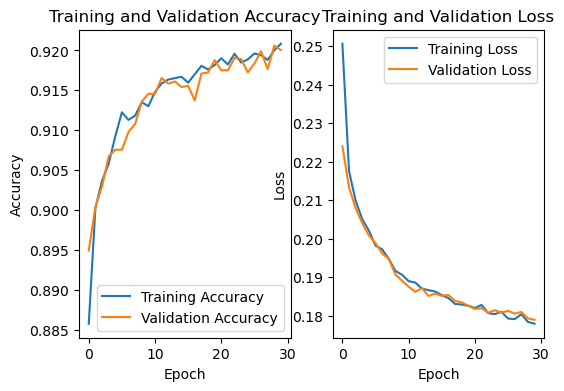

In [37]:
# Call the visualization functions after tuning and training
plot_tuning_results(tuner)

# Train the best model and plot its performance
with warnings.catch_warnings(action="ignore"): #UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
    best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=30, verbose=1)

plot_training_history(history)

279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


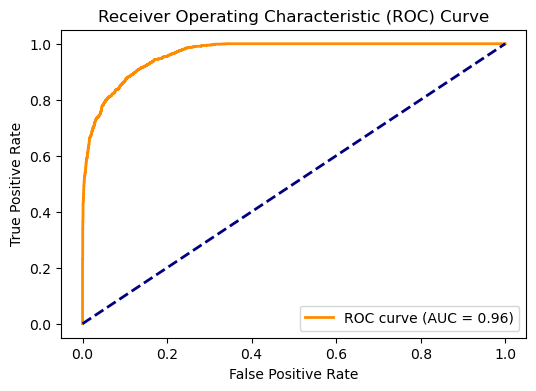

In [38]:
# Evaluate the ROC curve for the best model
NNB_roc_auc = plot_roc_curve(best_model, X_test, y_test)

In [39]:
# Predict probabilities and class labels for the test set
y_pred_probs = best_model.predict(X_test).ravel()  # Predict probabilities
y_pred_classes = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary class predictions

# Generate classification report
report_NNB= classification_report(y_test, y_pred_classes, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      6958
           1       0.83      0.75      0.79      1953

    accuracy                           0.91      8911
   macro avg       0.88      0.85      0.87      8911
weighted avg       0.91      0.91      0.91      8911



## 4.4 XGBoost with SMOTE 

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.6444444444444444, 'scale_pos_weight': 3.518955242804615, 'n_estimators': 190, 'max_depth': 10, 'learning_rate': 0.049999999999999996, 'colsample_bytree': 0.8666666666666667}
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      6939
           1       0.71      0.92      0.80      1972

    accuracy                           0.90      8911
   macro avg       0.84      0.91      0.87      8911
weighted avg       0.92      0.90      0.90      8911

F1-Score: 0.80
ROC-AUC: 0.97


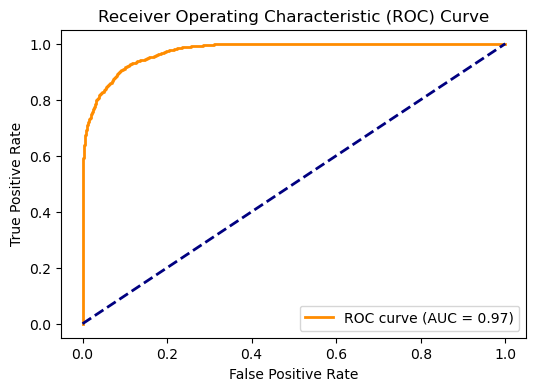

In [40]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Define parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': np.arange(50, 301, 10),  # Range from 50 to 300 in steps of 10
    'max_depth': np.arange(3, 11),           # Range from 3 to 10 (inclusive)
    'learning_rate': np.linspace(0.01, 0.3, 30),  # Continuous range from 0.01 to 0.3
    'subsample': np.linspace(0.6, 1.0, 10),       # Continuous range from 0.6 to 1.0
    'colsample_bytree': np.linspace(0.6, 1.0, 10),# Continuous range from 0.6 to 1.0
    'scale_pos_weight': [sum(y_train == 0) / sum(y_train == 1)],  # Calculate scale_pos_weight
}
# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='f1',  # Use F1 score for evaluation
    cv=3,  # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available CPUs
)

# Perform RandomizedSearchCV
with warnings.catch_warnings(action="ignore"): #UserWarning: [18:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: Parameters: { "use_label_encoder" } are not used.
    random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and evaluate
print(f"Best Parameters: {random_search.best_params_}")
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for positive class

# Classification report and evaluation metrics
print("Classification Report:")
report_XGB = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# F1-Score and ROC-AUC
f1 = f1_score(y_test, y_pred)
XGB_roc_auc = roc_auc_score(y_test, y_prob)

print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {XGB_roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {XGB_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Comparison of 4.1, 4.2, 4.3, 4.4 models

In [41]:
# getting values from the reports
accuracy_NN = report_NN['accuracy']
accuracy_XGB = report_XGB['accuracy']
accuracy_NNB = report_NNB['accuracy']

# Accuracy and ROC AUC values for each model
accuracies = [accuracy_NN, accuracy_XGB, accuracy_NNB]
roc_auc = [NN_roc_auc, XGB_roc_auc, NNB_roc_auc]

# Extracting precision, recall, f1-score for each model
metrics = ['precision', 'recall', 'f1-score']
classes = ['weighted avg']

# Initialize a list to store the data for precision, recall, and f1-score
metric_data = {
    'Metric': [],
    'NN': [],
    'XGB': [],
    'NNB': []
}

# Loop through each metric and class to populate the data dictionary for precision, recall, and f1-score
#print(metric_data)
for metric in metrics:
    for cls in classes:
        # Remove the " (weighted avg)" part from the Metric names
        metric_name = f'{metric} ({cls})'.replace(' (weighted avg)', '')
        
        metric_data['Metric'].append(metric_name)
        metric_data['NN'].append(report_NN.get(cls, {}).get(metric, ''))
        metric_data['XGB'].append(report_XGB.get(cls, {}).get(metric, ''))
        metric_data['NNB'].append(report_NNB.get(cls, {}).get(metric, ''))


# Create DataFrame for precision, recall, and f1-score
metric_df = pd.DataFrame()

metric_df = pd.DataFrame(metric_data)

# Add accuracy and ROC AUC as separate rows
accuracy_roc_auc_data = {
    'Metric': ['accuracy', 'roc_auc'],
    'NN': [accuracy_NN, NN_roc_auc],
    'XGB': [accuracy_XGB, XGB_roc_auc],
    'NNB': [accuracy_NNB, NNB_roc_auc]
}
#print(accuracy_roc_auc_data)

accuracy_roc_auc_df = pd.DataFrame(accuracy_roc_auc_data)

# Concatenate both DataFrames (metric_df and accuracy_roc_auc_df)
combined_report = pd.concat([metric_df, accuracy_roc_auc_df], ignore_index=True)

# Display the combined table
combined_report

combined_report["Metric"] = combined_report["Metric"].replace({
        "f1-score": "F1-Score", 
    "roc_auc": "ROC AUC", 
    "precision": "Precision", 
    "recall": "Recall",  
    "accuracy": "Accuracy"
})

# Making sure that original metrics_df does not get changed, so the code can be run again.
metrics_df2 = metrics_df.reset_index()

metrics_df2.rename(columns={"index": "Metric"}, inplace=True)

combined = pd.merge(combined_report, metrics_df2, on="Metric")
combined = combined.drop(columns=["NN", "Poly SVM" , "Linear SVM"])
combined

,Metric,XGB,NNB,RBF SVM,Logistic Regression
0,Precision,0.916800,0.910424,0.723701,0.663915
1,Recall,0.899562,0.912580,0.868661,0.856491
2,F1-Score,0.903816,0.910868,0.789583,0.748007
3,Accuracy,0.899562,0.912580,0.897542,0.872293
4,ROC AUC,0.974431,0.964756,0.959713,0.949180


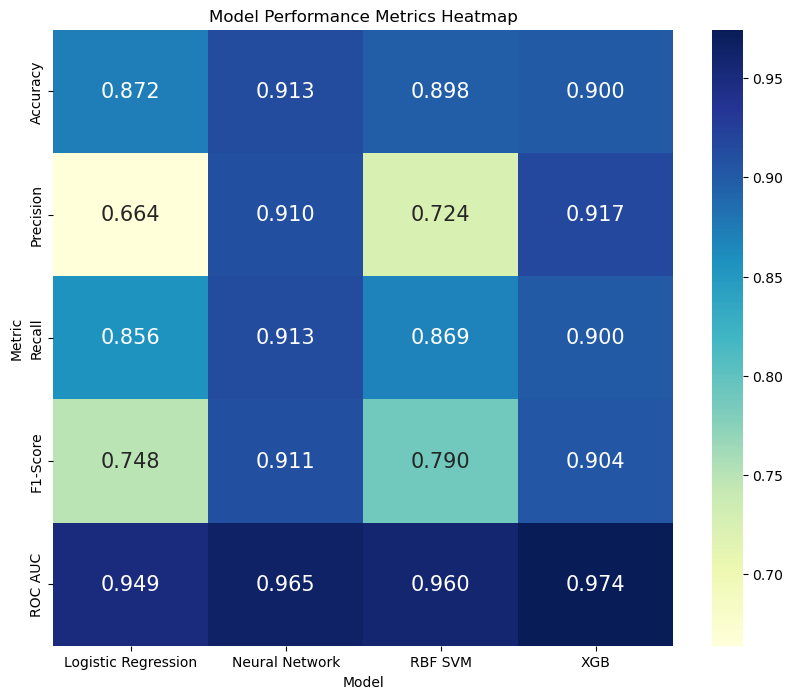

<Figure size 640x480 with 0 Axes>

In [42]:
# Reshaping the DataFrame for heatmap
df_melted = combined.melt(id_vars=["Metric"], var_name="Model", value_name="Score")
df_pivot = df_melted.pivot(index="Metric", columns="Model", values="Score")
model_rename = {
    'XGB': 'XGB',
    'NNB': 'Neural Network',
    'Logistic Regression': 'Logistic Regression',
    'RBF SVM': 'RBF SVM', 
}
df_pivot.rename(columns=model_rename, inplace=True)
order = ['Accuracy', 'Precision', 'Recall','F1-Score', 'ROC AUC']
df_pivot = df_pivot.loc[order]

# Creating the heatmap with larger value labels
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_pivot, 
    annot=True, 
    fmt=".3f", 
    cmap="YlGnBu", 
    cbar=True,
    annot_kws={"size": 15}  # Adjust the size as needed
)
plt.title("Model Performance Metrics Heatmap")
plt.show()
# Saving the heatmap to a file
plt.savefig('figures/model_performance_heatmap.png', dpi=300, bbox_inches='tight')


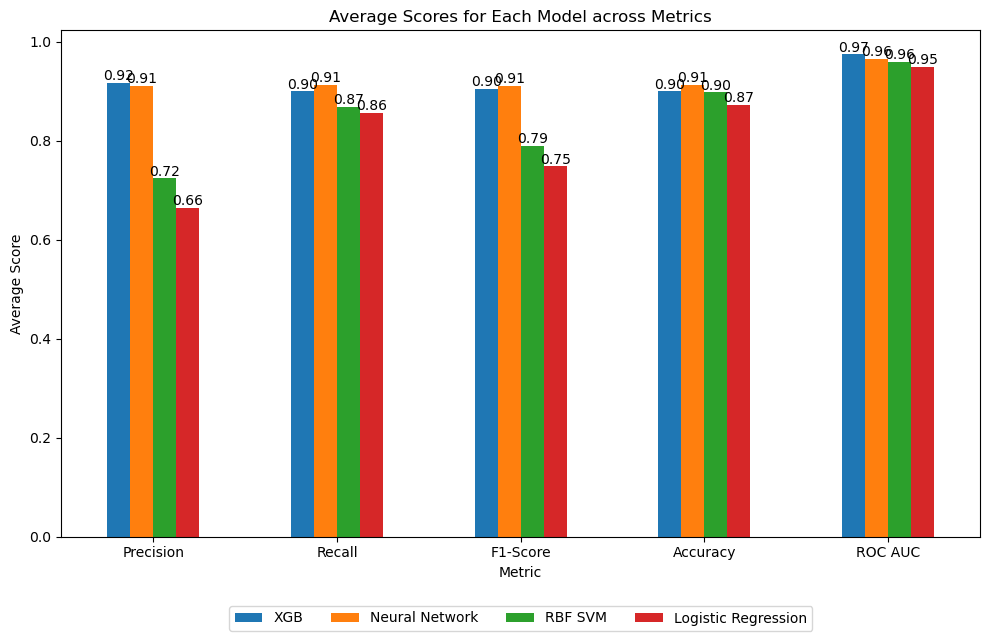

In [43]:
# Rename the models in the legend
model_rename = {
    'XGB': 'XGB',
    'NNB': 'Neural Network',
    'Logistic Regression': 'Logistic Regression',
    'RBF SVM' : 'RBF SVM', 

}

# Plot the results
ax = combined.set_index('Metric').plot(kind='bar', figsize=(10, 6))

# Add data labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize plot
plt.title('Average Scores for Each Model across Metrics')
plt.ylabel('Average Score')
plt.xticks(rotation=360)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Set model names in the legend and place it at the bottom
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, [model_rename[l]for l in labels], loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4)
# Show plot
plt.show()

## 4.5 Decision Tree

In [44]:
random_v = 42
np.random.seed(random_v)
random.seed(random_v)


In [45]:
data_cleaned3['log_loan_amnt'] = np.log1p(data_cleaned3['loan_amnt'])
data_cleaned3 = data_cleaned3.drop(columns=['person_income', 'loan_amnt'])

In [46]:
# Prepare the data for training
X = data_cleaned3.drop(columns=['loan_status'])  # Features # Formerly named Features
y = data_cleaned3['loan_status']  # Target variable # Formerly named label

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #Formerly named features_scaled



# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_v)


In [47]:
# Data imbalance
y_train.value_counts()

loan_status
0    27735
1     7906
Name: count, dtype: int64

In [48]:
# Fix for data imbalance.
sm = SMOTE(random_state=random_v, k_neighbors=5)# 5 is default anyway
X_train, y_train = sm.fit_resample(X_train,y_train)

In [49]:
y_train.value_counts()

loan_status
1    27735
0    27735
Name: count, dtype: int64

In [50]:
# Making the classifier. 
dtc = DecisionTreeClassifier(random_state=random_v)


In [51]:
## Determining parameter limits: Total features
len(X.columns)


19

In [52]:
#Determining parameter limits: Upper bound for depth.
# "If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples"
# Tree without depth limit.
dtc.fit(X_train,y_train)
print(dtc.tree_.max_depth)
dtc = DecisionTreeClassifier(random_state=random_v)


31


In [ ]:
# Using GridSearchCV to find good hyperparameters.
parameters = {"criterion":["gini", "entropy","log_loss"],
             "max_depth": [None, 5, 30, 31 ], # 1 to 31
             "max_features":[None, 5, 15, 19], ## 1 to 19
             "max_leaf_nodes": [None, 10, 50, 100], #  2 to (2^max_depth)
             "min_samples_leaf":[1,10],
             "min_samples_split":[2,10]}
GS0 = GridSearchCV(dtc,parameters, verbose=0)

### First run of GridSearch

#### Rerun

In [ ]:
GS0.fit(X_train, y_train)

#### Import

In [88]:
#pickle.dump(GS0, open('models/GS0.pkl','wb'))
GS0 = pickle.load(open('models/GS0.pkl','rb'))

#### Analysis

In [54]:
GS0.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 15,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [55]:
prediction = GS0.predict(X_train)
print("Accuracy on training set: "+ str(accuracy_score(y_train,prediction)))
print("F1 score on training set: "+str(f1_score(y_train, prediction)))
confusion_matrix(y_train, prediction, labels  =[1,0])

Accuracy on training set: 1.0
F1 score on training set: 1.0


array([[27735,     0],
       [    0, 27735]], dtype=int64)

Scores of 1.0 are most likely a sign of overfitting.


### Second run of GridSearch

In [56]:
# Changes.
# Removed one criterion option.
# Must pick a max depth. Smaller range
# Maximum features 19 was redundant and has been replace with 15.
parameters = {"criterion":["gini", "entropy"],
             "max_depth": [10, 20, 25 ], # 1 to 31
             "max_features":[None, 4, 5, 15], ## 1 to 19
             "max_leaf_nodes": [None, 10, 50, 100], #  2 to (2^max_depth)
             "min_samples_leaf":[1,10],
             "min_samples_split":[2,10]}

#### Rerun

In [ ]:
GS1 = GridSearchCV(dtc,parameters, verbose=0)
GS1.fit(X_train, y_train)

#### Import

In [93]:
#pickle.dump(GS1, open('models/GS1.pkl','wb'))
GS1 = pickle.load(open('models/GS1.pkl','rb'))


#### Analysis

In [58]:
GS1.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [59]:

prediction = GS1.predict(X_train)
print("Accuracy on training set: "+ str(accuracy_score(y_train,prediction)))
print("F1 score on training set: "+str(f1_score(y_train, prediction)))
confusion_matrix(y_train, prediction, labels  =[1,0])

Accuracy on training set: 0.9990445285740039
F1 score on training set: 0.9990450278383395


array([[27723,    12],
       [   41, 27694]], dtype=int64)

Still a bit too good for a singel tree.

### Third run of GridSearch

In [60]:
# Changes.
# Removed another criterion option.
# Removed highest max depth.
# Maximum features 19 was redundant and has been replace with 15.
# Max features can not be none.
parameters = {"criterion":["gini"],
             "max_depth": [ 10, 20], # 1 to 40
             "max_features":[5, 10, 15], ## 1 to 19
             "max_leaf_nodes": [None, 10, 50, 100], #  2 to (2^max_depth)
             "min_samples_leaf":[1,10],
             "min_samples_split":[2,10]}

#### Rerun

In [ ]:
GS2 = GridSearchCV(dtc,parameters, verbose=0)
GS2.fit(X_train, y_train)

#### Import

In [91]:
#pickle.dump(GS2, open('models/GS2.pkl','wb'))
GS2 = pickle.load(open('models/GS2.pkl','rb'))


#### Analysis

In [62]:
GS2.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 10,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [63]:
prediction = GS2.predict(X_train)
print("Accuracy on training set: "+ str(accuracy_score(y_train,prediction)))
print("F1 score on training set: "+str(f1_score(y_train, prediction)))
confusion_matrix(y_train, prediction, labels  =[1,0])

Accuracy on training set: 0.9789976563908419
F1 score on training set: 0.9790772435839874


array([[27258,   477],
       [  688, 27047]], dtype=int64)

These hyperparameters are quite a bit more limiting than the first two sets. I feel more confident that the model will now generalize better. However I feel like 10 features is not enough.

In [64]:
test = DecisionTreeClassifier(max_depth=20, max_features=15, min_samples_leaf=10)
test.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=20, max_features=15, min_samples_leaf=10)

In [65]:
prediction = test.predict(X_train)
print("Accuracy on training set: "+ str(accuracy_score(y_train,prediction)))
print("F1 score on training set: "+str(f1_score(y_train, prediction)))
confusion_matrix(y_train, prediction, labels  =[1,0])

Accuracy on training set: 0.9461691004146385
F1 score on training set: 0.9461885024328708


array([[26252,  1483],
       [ 1503, 26232]], dtype=int64)

In [66]:
best_tree = GS2.best_estimator_
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, max_features=10, random_state=42)

In [67]:
prediction = best_tree.predict(X_test)
print("Accuracy on test set: "+ str(accuracy_score(y_test,prediction)))
print("F1 score on test set: "+str(f1_score(y_test, prediction)))
confusion_matrix(y_test, prediction, labels  =[1,0])

Accuracy on test set: 0.8804847940747391
F1 score on test set: 0.7460052468399714


array([[1564,  389],
       [ 676, 6282]], dtype=int64)

Acceptable results overall. Of note is the false positive to false negative ratio, with noticeably more false positives. This is most likely caused by the dataset’s imbalance. 

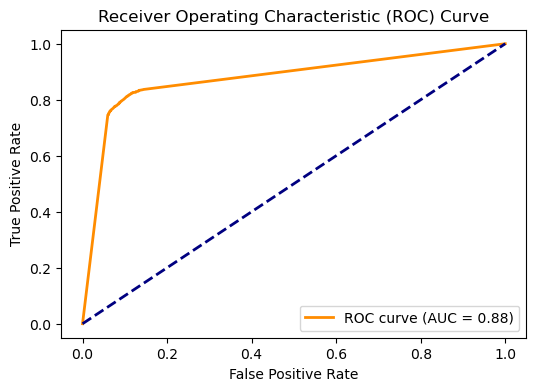

0.8759290436496531

In [68]:
from sklearn.metrics import roc_curve, auc # For some reason need to reimport.

# Function to plot the ROC curve
def plot_roc_curve_tree(model, X_test, y_test):
    # Predict probabilities
    #y_prob = model.predict(X_test).ravel()
    y_prob =[]
    for x in model.predict_proba(X_test):
        y_prob.append(x[1])
        

    
    #y_prob = model.predict_proba(X_test)
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc
# Evaluate the ROC curve for the best model
plot_roc_curve_tree(GS2, X_test, y_test)


Seems to still be overfitted.
Trying the slightly modified one now.

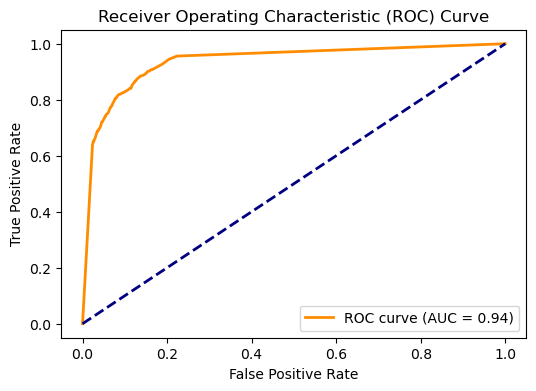

In [69]:
tree_roc_auc=plot_roc_curve_tree(test, X_test, y_test)

The test version seems to work quite a bit better!

In [70]:
# Predict probabilities and class labels for the test set
y_pred_classes = test.predict(X_test)

# Generate classification report
report_tree= classification_report(y_test, y_pred_classes, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      6958
           1       0.71      0.82      0.76      1953

    accuracy                           0.89      8911
   macro avg       0.83      0.86      0.84      8911
weighted avg       0.90      0.89      0.89      8911



## 4.6 Random Forest

I believe that accurate predictions should be possible without touching most of the hyperparameters when using the forest. The data seems simple enough.

### Default forest

In [71]:
rfc = RandomForestClassifier(random_state=random_v)
parameters = {"n_estimators":[200]}


In [72]:
rfc_default = RandomForestClassifier(n_estimators=100,random_state=random_v)

In [73]:
rfc_default.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
prediction = rfc_default.predict(X_train)
print("Accuracy on training set: "+ str(accuracy_score(y_train,prediction)))
print("F1 score on training set: "+str(f1_score(y_train,prediction)))
confusion_matrix(y_train, prediction, labels  =[1,0])

Accuracy on training set: 1.0
F1 score on training set: 1.0


array([[27735,     0],
       [    0, 27735]], dtype=int64)

Too perfect, but we will see.

In [75]:
prediction = rfc_default.predict(X_test)
print("Accuracy on test set: "+ str(accuracy_score(y_test,prediction)))
print("F1 score on test set: "+str(f1_score(y_test,prediction)))
confusion_matrix(y_test,prediction, labels  =[1,0])

Accuracy on test set: 0.9138143867130513
F1 score on test set: 0.8087649402390438


array([[1624,  329],
       [ 439, 6519]], dtype=int64)

A Random Forest seems to work very well with this dataset!

### Modified algorithm

In [76]:
parameters = {"criterion":["gini"],
             "max_depth": [None, 5, 30], # 1 to 31
             "max_features":[None, 5, 15], ## 1 to 19
             "max_leaf_nodes": [None,50, 100], #  2 to (2^max_depth)
             "min_samples_leaf":[1,20],
             "min_samples_split":[2,20]}

In [77]:
# RandomizedSearchCV instead of GridSearchCV because forest take a long time with that.
RS_F1 = RandomizedSearchCV(rfc_default,parameters, verbose=0)

#### Rerun

In [ ]:
RS_F1.fit(X_train, y_train)

#### Import

In [87]:
pickle.dump(RS_F1, open('models/RS_F1.pkl','wb'))
RS_F1 = pickle.load(open('models/RS_F1.pkl','rb'))

#### Analysis

In [80]:
print(RS_F1.best_params_)
prediction = RS_F1.predict(X_train)
print("Accuracy on training set: "+ str(accuracy_score(y_train,prediction)))
print("F1 score on training set: "+str(f1_score(y_train,prediction)))
confusion_matrix(y_train, prediction, labels  =[1,0])

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': 5, 'max_depth': 30, 'criterion': 'gini'}
Accuracy on training set: 1.0
F1 score on training set: 1.0


array([[27735,     0],
       [    0, 27735]], dtype=int64)

In [81]:
prediction = RS_F1.predict(X_test)
print("Accuracy on test set: "+ str(accuracy_score(y_test,prediction)))
print("F1 score on test set: "+str(f1_score(y_test,prediction)))
confusion_matrix(y_test,prediction, labels  =[1,0])

Accuracy on test set: 0.9129166199079789
F1 score on test set: 0.8077304261645193


array([[1630,  323],
       [ 453, 6505]], dtype=int64)

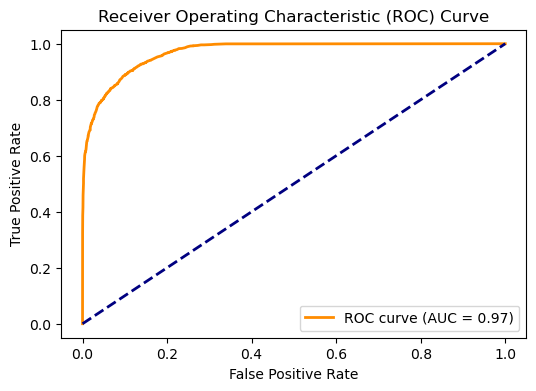

In [82]:
RF_roc_auc = plot_roc_curve_tree(RS_F1.best_estimator_, X_test, y_test)


In [83]:
# Predict probabilities and class labels for the test set
y_pred_classes = RS_F1.predict(X_test)

# Generate classification report
report_forest= classification_report(y_test, y_pred_classes, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      6958
           1       0.78      0.83      0.81      1953

    accuracy                           0.91      8911
   macro avg       0.87      0.88      0.88      8911
weighted avg       0.92      0.91      0.91      8911



# Final Comparsions 

In [84]:
# getting values from the reports
accuracy_tree = report_tree["accuracy"]
accuracy_forest = report_forest["accuracy"]

# Accuracy and ROC AUC values for each model
accuracies = [accuracy_tree, accuracy_forest]
roc_auc = [tree_roc_auc, RF_roc_auc]

# Extracting precision, recall, f1-score for each model
metrics = ['precision', 'recall', 'f1-score']
classes = ['weighted avg']

# Initialize a list to store the data for precision, recall, and f1-score
metric_data = {
    'Metric': [],
    "TREE":[],
    "RF":[]
}

# Loop through each metric and class to populate the data dictionary for precision, recall, and f1-score
for metric in metrics:
    for cls in classes:
        # Remove the " (weighted avg)" part from the Metric names
        metric_name = f'{metric} ({cls})'.replace(' (weighted avg)', '')
        metric_data['Metric'].append(metric_name)
        metric_data['TREE'].append(report_tree.get(cls, {}).get(metric, ''))
        metric_data['RF'].append(report_NNB.get(cls, {}).get(metric, ''))

# Create DataFrame for precision, recall, and f1-score
metric_df = pd.DataFrame()

metric_df = pd.DataFrame(metric_data)

# Add accuracy and ROC AUC as separate rows
accuracy_roc_auc_data = {
    'Metric': ['accuracy', 'roc_auc'],
    "TREE": [accuracy_tree, tree_roc_auc],
    "RF": [accuracy_forest, RF_roc_auc]
}
#print(accuracy_roc_auc_data)


accuracy_roc_auc_df = pd.DataFrame(accuracy_roc_auc_data)
# Concatenate both DataFrames (metric_df and accuracy_roc_auc_df)
combined_report = pd.concat([metric_df, accuracy_roc_auc_df], ignore_index=True)

# Display the combined table
combined_report

combined_report["Metric"] = combined_report["Metric"].replace({
        "f1-score": "F1-Score", 
    "roc_auc": "ROC AUC", 
    "precision": "Precision", 
    "recall": "Recall",  
    "accuracy": "Accuracy"
})




combined2 = pd.merge(combined_report, combined, on="Metric")
combined2

,Metric,TREE,RF,XGB,NNB,RBF SVM,Logistic Regression
0,Precision,0.895568,0.910424,0.916800,0.910424,0.723701,0.663915
1,Recall,0.886769,0.912580,0.899562,0.912580,0.868661,0.856491
2,F1-Score,0.889764,0.910868,0.903816,0.910868,0.789583,0.748007
3,Accuracy,0.886769,0.912917,0.899562,0.912580,0.897542,0.872293
4,ROC AUC,0.935845,0.969413,0.974431,0.964756,0.959713,0.949180


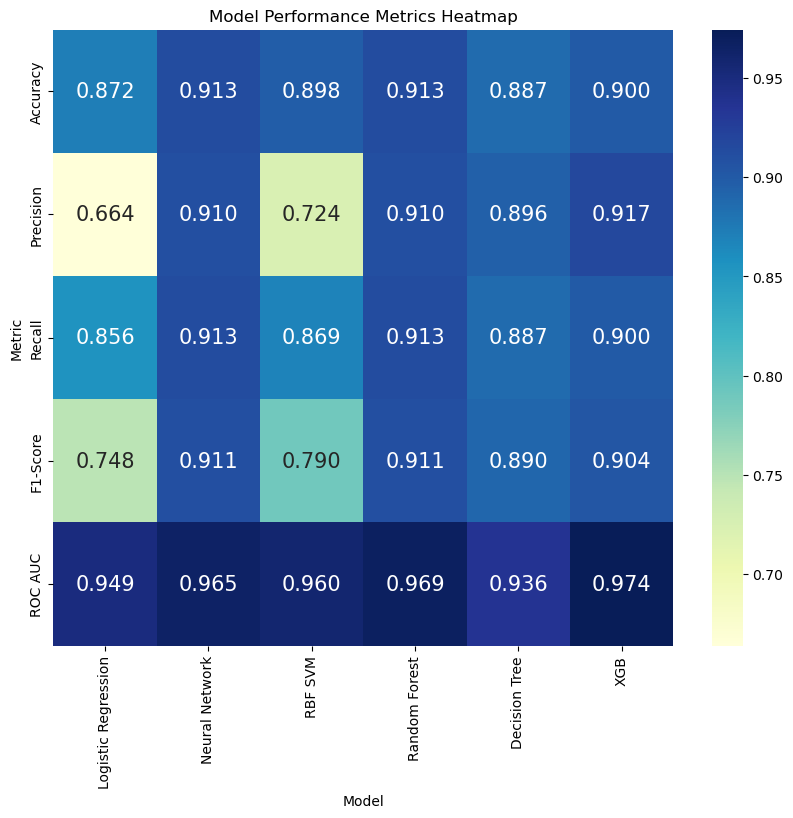

<Figure size 640x480 with 0 Axes>

In [85]:
# Reshaping the DataFrame for heatmap
df_melted = combined2.melt(id_vars=["Metric"], var_name="Model", value_name="Score")
df_pivot = df_melted.pivot(index="Metric", columns="Model", values="Score")
model_rename = {
    'XGB': 'XGB',
    'NNB': 'Neural Network',
    'Logistic Regression': 'Logistic Regression',
    'RBF SVM': 'RBF SVM', 
    "RF" : "Random Forest",
    "TREE": "Decision Tree"
}
df_pivot.rename(columns=model_rename, inplace=True)
order = ['Accuracy', 'Precision', 'Recall','F1-Score', 'ROC AUC']
df_pivot = df_pivot.loc[order]

# Creating the heatmap with larger value labels
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_pivot, 
    annot=True, 
    fmt=".3f", 
    cmap="YlGnBu", 
    cbar=True,
    annot_kws={"size": 15}  # Adjust the size as needed
)
plt.title("Model Performance Metrics Heatmap")
plt.show()
# Saving the heatmap to a file
plt.savefig('figures/model_performance_heatmap2.png', dpi=300, bbox_inches='tight')

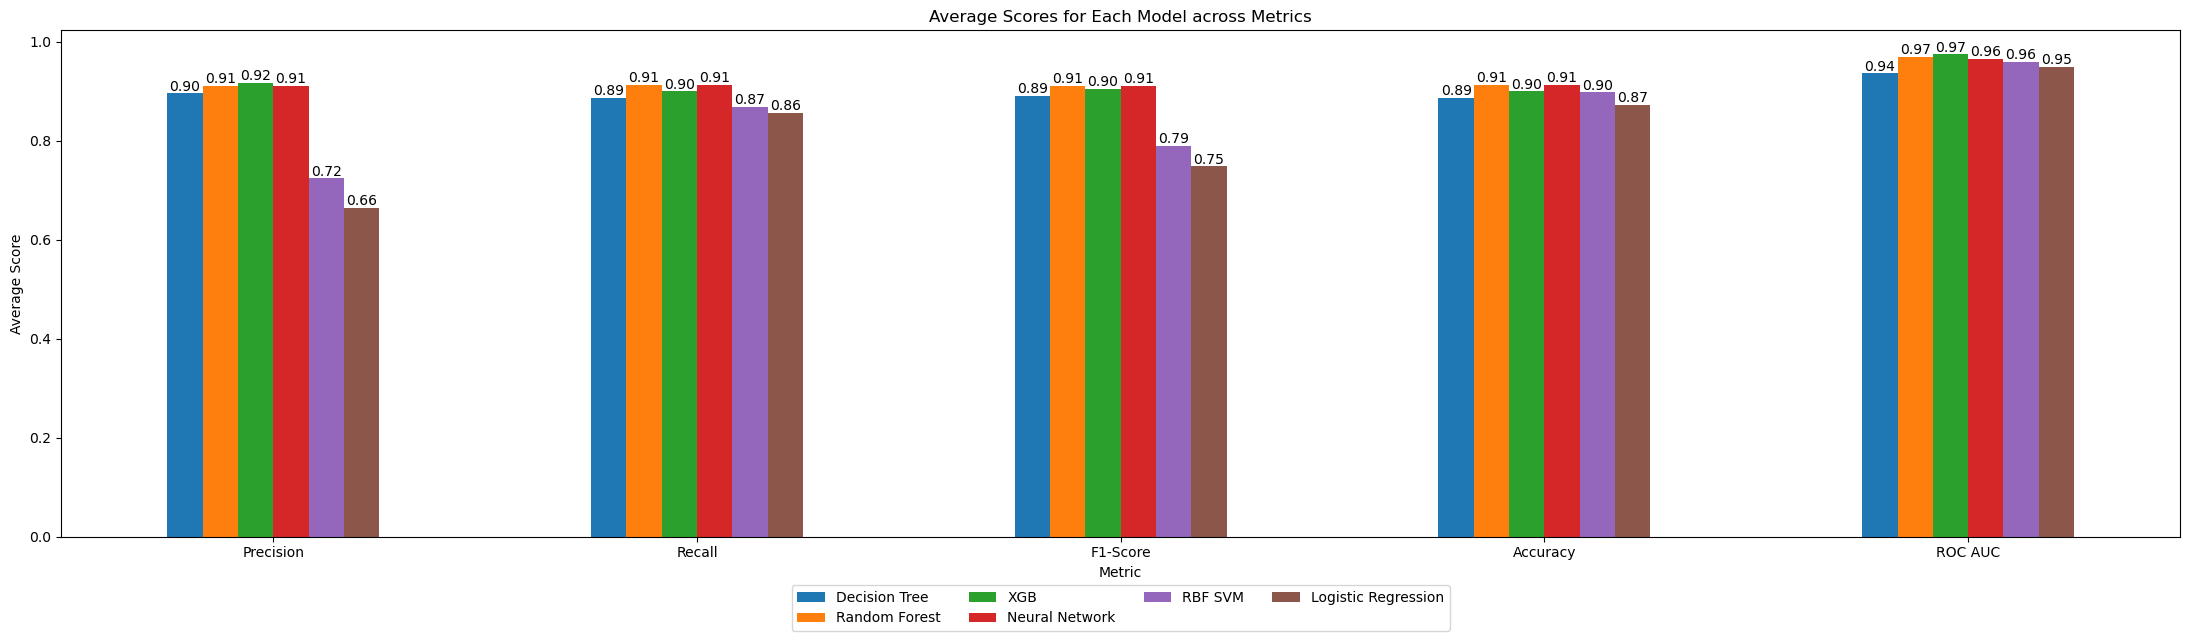

In [86]:
# Rename the models in the legend
#
model_rename = {
   'XGB': 'XGB',
   'NNB': 'Neural Network',
  'Logistic Regression': 'Logistic Regression',
   'RBF SVM' : 'RBF SVM', 
   "RF" : "Random Forest",
  "TREE": "Decision Tree"
    
    
}

# Plot the results
ax = combined2.set_index('Metric').plot(kind='bar', figsize=(22, 6))

# Add data labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize plot
plt.title('Average Scores for Each Model across Metrics')
plt.ylabel('Average Score')
plt.xticks(rotation=360)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Set model names in the legend and place it at the bottom
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, [model_rename[l]for l in labels], loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4)

# Show plot
plt.show()